# ==============================================
# Notebook for Logit Lens and Hidden Acts ======
# ==============================================

In [ ]:
from pathlib import Path
from datasets import load_dataset, DownloadMode
import torch
import os
import glob
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from old_lens.mi_utils.quant_configs.bnb_configs import load_bnb_in_4bit

# ==============================================
# Models & Dataset =============================
# ==============================================

In [ ]:
filepath = r'D:\LogitLensData\nq'

destination_path = str(Path(filepath))
nq_dataset = load_dataset(
    'sentence-transformers/natural-questions',
    split={
        'train': 'train[:1000]'
    },
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS,
    keep_in_memory=True
)

nq_queries = nq_dataset['train']['query']
nq_answers = nq_dataset['train']['answer']

In [ ]:
nq_1000 = nq_queries[:1000]

In [ ]:
nq_500 = nq_queries[:500]

In [ ]:
from enum import Enum

class Models(Enum):
    LAIN8B = "Models/LLaMA3Instruct"
    HF100B = "Models/HF1BitLLM100Btokens"


class Names(Enum):
    LAIN8B = "Meta-Llama-3-8B-Instruct-fp"
    HF100B = "Llama3-8B-1.58-100B-tokens"

In [ ]:
def load_model_and_tok(
    model_name: str,
    low_cpu_mem_usage: bool = True,
    local_files_only: bool = True,
    device_map: str = "cpu",
    dtype: torch.dtype = torch.float32,
    load_in_8bit: bool = False
):
    tok = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        output_hidden_states=True,
        return_dict_in_generate=True,
        return_dict=True,
        output_attentions=True,
        low_cpu_mem_usage=low_cpu_mem_usage,
        local_files_only=local_files_only,
        device_map=device_map,
        load_in_8bit=load_in_8bit,
        torch_dtype=dtype,
        attn_implementation="eager",
    )
    return model, tok

In [ ]:
model_orig, orig_tokenizer = load_model_and_tok(Models.LAIN8B.value) 

In [ ]:
eos_token_id = orig_tokenizer.eos_token_id
bos_token_id = orig_tokenizer.bos_token_id
print(f"eos: {eos_token_id}\nbos: {bos_token_id}")

In [ ]:
model_8bit, orig_tokenizer = load_model_and_tok(Models.LAIN8B.value, dtype=torch.float16, load_in_8bit=True) 

In [ ]:
model_4bit, orig_tokenizer = load_bnb_in_4bit(Models.LAIN8B.value, double_quant=False, dtype=torch.float16, device_map="cpu") 

In [ ]:
model_quant, quant_tokenizer = load_model_and_tok(Models.HF100B.value) 

In [ ]:
lengths = []
for q in nq_500:
    ids = orig_tokenizer.encode(q, add_special_tokens=True)
    lengths.append(len(ids))

print("=== Token Length Statistics (LLaMA-3-8B-Instruct tokenizer) ===")
print(f"Samples analyzed: {len(lengths)}")
print(f"Mean length:       {np.mean(lengths):.2f}")
print(f"Median length:     {np.median(lengths):.0f}")
print(f"90th percentile:   {np.percentile(lengths, 90):.0f}")
print(f"95th percentile:   {np.percentile(lengths, 95):.0f}")
print(f"Max observed len:  {np.max(lengths)}")
print(f"Min observed len:  {np.min(lengths)}")

In [ ]:
import inspect
sig = inspect.signature(model_orig.model.layers[0].forward)
print(sig)

In [ ]:
import os
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig


MODELS = {
    "base_fp32": {
        "path": "meta-llama/Llama-2-7b-hf",
        "quant": None
    },
    "bnb_8bit": {
        "path": "meta-llama/Llama-2-7b-hf",
        "quant": BitsAndBytesConfig(load_in_8bit=True, torch_dtype=torch.float16)
    },
    "bnb_4bit": {
        "path": "meta-llama/Llama-2-7b-hf",
        "quant": BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            torch_dtype=torch.float16
        )
    },
}

SAVE_DIR = "weights_extracted" 
os.makedirs(SAVE_DIR, exist_ok=True)


def extract_and_save_weights(model_name: str, model_cfg: dict):
    print(f"\n🔹 Extracting weights from {model_name} ...")

    model = AutoModelForCausalLM.from_pretrained(
        model_cfg["path"],
        quantization_config=model_cfg["quant"],
        device_map="auto"
    )

    out_dir = os.path.join(SAVE_DIR, model_name)
    os.makedirs(out_dir, exist_ok=True)

    for name, param in model.named_parameters():
        # Detach, dequantize (if needed), and upcast to float32
        w = param.detach().clone().to(torch.float32).cpu()

        fname = name.replace(".", "_") + ".pt"
        torch.save(w, os.path.join(out_dir, fname))

    print(f"Saved float32 weights for {model_name} to {out_dir}")

    # small sanity check
    total_params = sum(p.numel() for p in model.parameters())
    print(f"   Total parameters: {total_params:,}")
    print(f"   Example tensor dtype: {w.dtype}, shape: {tuple(w.shape)}")



for model_name, model_cfg in MODELS.items():
    extract_and_save_weights(model_name, model_cfg)

In [ ]:
import torch, glob

base_w = torch.load("weights_extracted/base_fp32/model_layers_0_self_attn_q_proj_weight.pt")
bnb_w = torch.load("weights_extracted/bnb_8bit/model_layers_0_self_attn_q_proj_weight.pt")

print(base_w.dtype, bnb_w.dtype)
print("Mean abs diff:", (base_w - bnb_w).abs().mean().item())
print("Cosine similarity:", torch.nn.functional.cosine_similarity(
    base_w.flatten(), bnb_w.flatten(), dim=0
).item())

# ==============================================
# Logit Lens with Normaliztion =================
# ==============================================

In [ ]:
import torch
import torch.nn.functional as F
from pathlib import Path
from tqdm import tqdm
import numpy as np
import gc
import warnings
warnings.filterwarnings("ignore", message="MatMul8bitLt: inputs will be cast")


# ============================================================
# Normalization modes
# ============================================================
def apply_normalization(x, model, normalize_mode="raw", block=None, layer_index=None):
    x = x.to(torch.float32) 
    
    if normalize_mode == "raw":
        return x

    elif normalize_mode == "unit_rms":
        if layer_index == -1:
            return x
        elif block is not None:
            eps = 1e-5
            return x / (x.pow(2).mean(dim=-1, keepdim=True).add(eps).sqrt())
        else:
            return x

    elif normalize_mode == "rms_layer":
        if layer_index == -1:
            return x
        elif block is not None:
            return block.post_attention_layernorm(x.to(torch.float32))
        else:
            return x

    elif normalize_mode == "norm_rms":
        if layer_index == -1:
            return x
        elif block is not None:
            return model.model.norm(x).to(torch.float32)
        else:
            return x

    else:
        raise ValueError(f"Unknown normalization_mode: {normalize_mode}")


# ============================================================
# Helper: causal + padding mask for LLaMA blocks
# ============================================================
def build_full_attention_mask(input_ids, attention_mask, device, model=None):
    bsz, seq_len = input_ids.shape

    causal = torch.triu(
        torch.ones((seq_len, seq_len), device=device, dtype=torch.bool), diagonal=1
    ).unsqueeze(0).unsqueeze(0)

    if attention_mask is None:
        padding_mask = torch.zeros((bsz, 1, 1, seq_len), device=device, dtype=torch.bool)
    else:
        padding_mask = (attention_mask[:, None, None, :] == 0)

    full = causal | padding_mask

    attn_impl = getattr(getattr(model, "config", None), "attn_implementation", None)
    attn_impl = attn_impl or "eager" 

    if attn_impl in ["flash_attention_2", "sdpa"]:
        return full.to(torch.bool)
    else:
        return full.to(torch.float32) * -1e9


# ============================================================
# Collector with multiple normalization variants + attention weights (optional storage)
# ============================================================
@torch.no_grad()
def collect_logit_lens_full(
    model,
    tokenizer,
    prompts,
    batch_index=0,
    max_len=17,
    device=None,
    clamp_logits=False,         
    clamp_value=100.0,         
    save_path=None,
    collect_attn=True,
    save_attn=True,
    norm_modes=("raw", "unit_rms", "norm_rms"),
):

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    bnb_layer_types = ("Linear4bit", "Linear8bitLt")
    is_quantized = any(any(name in type(m).__name__ for name in bnb_layer_types)
                       for m in model.modules())

    if is_quantized:
        try:
            first_param_device = next(model.parameters()).device
        except StopIteration:
            first_param_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[info] Detected quantized model → device {first_param_device}")
        model.eval()
    else:
        model = model.to(device).eval()

    Path(save_path).parent.mkdir(parents=True, exist_ok=True)

    # ============================================================
    # Tokenization
    # ============================================================
    encoded = []
    pad_id = tokenizer.pad_token_id or tokenizer.eos_token_id
    bos_id = tokenizer.bos_token_id
    eos_id = tokenizer.eos_token_id

    for p in prompts:
        ids = tokenizer.encode(p, add_special_tokens=False)
        content = ids[: max_len - 2]
        ids = torch.tensor([bos_id] + content + [eos_id], dtype=torch.long)
        if len(ids) < max_len:
            ids = F.pad(ids, (0, max_len - len(ids)), value=pad_id)
        encoded.append(ids)

    input_ids = torch.stack(encoded, dim=0).to(device)

    # ============================================================
    # Build attention mask (stop after first EOS)
    # ============================================================
    attention_mask = torch.ones_like(input_ids, dtype=torch.long)
    for i, ids in enumerate(input_ids):
        eos_positions = (ids == eos_id).nonzero(as_tuple=True)[0]
        if len(eos_positions) > 0:
            eos_pos = eos_positions[0].item()
            attention_mask[i, eos_pos + 1:] = 0

    batch_size, seq_len = input_ids.shape
    full_mask = build_full_attention_mask(input_ids, attention_mask, device)
    #print(f"[mask] dtype={full_mask.dtype}, shape={tuple(full_mask.shape)}, example={full_mask.flatten()[0].item()}")
    print(
        f"[mask] dtype={full_mask.dtype}, shape={tuple(full_mask.shape)}, "
        f"min={full_mask.min().item()}, max={full_mask.max().item()}, "
        f"unique={torch.unique(full_mask)}"
    )
    assert (full_mask == 0).sum() < full_mask.numel(), "Mask seems to contain only zeros — check logic!"

    position_ids = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, -1)
    vocab_size = model.lm_head.out_features

    print(f"[info] Tokenized {batch_size} prompts | seq_len={seq_len}")
    print(f"[info] Collecting from {len(model.model.layers)} layers | quantized={is_quantized}")

    # ============================================================
    # Projection helper (with consistent upcasting and sanitization)
    # ============================================================
    def project(x):
        x_fp32 = x.to(torch.float32)

        head_dtype = next(model.lm_head.parameters()).dtype
        x_cast = x_fp32.to(head_dtype)

        logits = model.lm_head(x_cast)

        logits = torch.nan_to_num(logits, nan=0.0, posinf=0.0, neginf=0.0)

        if clamp_logits and is_quantized:
            logits = logits.clamp(-clamp_value, clamp_value)

        return logits.to(torch.float32)

    # ============================================================
    # Collection containers
    # ============================================================
    rows = []
    all_hidden, all_logits, all_attn = {}, {}, {}

    # ============================================================
    # Embedding layer
    # ============================================================
    x = model.model.embed_tokens(input_ids).to(torch.float32)
    hidden_variants = {mode: apply_normalization(x.clone(), model, mode, layer_index=-1)
                       for mode in norm_modes}
    logits_variants = {mode: project(hidden_variants[mode]) for mode in norm_modes}

    for mode in norm_modes:
        all_hidden[f"embed_tokens_{mode}"] = hidden_variants[mode].cpu()
        all_logits[f"embed_tokens_{mode}"] = logits_variants[mode].cpu()

    for i in range(batch_size):
        rows.append({
            "prompt_id": i,
            "prompt_text": prompts[i],
            "batch_index": batch_index,
            "vocab_size": vocab_size,
            "layer_index": -1,
            "layer_name": "embed_tokens",
            "input_ids": input_ids[i].cpu(),
            "target_ids": input_ids[i, 1:].cpu(),
            "attention_mask": attention_mask[i].cpu(),
            **{f"hidden_{m}": hidden_variants[m][i, :-1].cpu() for m in norm_modes},
            **{f"logits_{m}": logits_variants[m][i, :-1].cpu() for m in norm_modes},
        })

    # ============================================================
    # Transformer layers
    # ============================================================
    for li, block in enumerate(model.model.layers):
        out = block(
            x, position_ids=position_ids,
            attention_mask=full_mask,
            output_attentions=collect_attn,
        )
        x = out[0]
        attn = out[1] if collect_attn else None

        layer_output = x.detach().clone().to(torch.float32)
        hidden_variants = {
            mode: apply_normalization(layer_output.clone(), model, mode, block=block, layer_index=li)
            for mode in norm_modes
        }
        logits_variants = {mode: project(hidden_variants[mode]) for mode in norm_modes}

        for mode in norm_modes:
            hidden_variants[mode] = hidden_variants[mode][:, :-1, :]
            logits_variants[mode] = logits_variants[mode][:, :-1, :]

        for mode in norm_modes:
            all_hidden[f"layer.{li}_{mode}"] = hidden_variants[mode].cpu()
            all_logits[f"layer.{li}_{mode}"] = logits_variants[mode].cpu()

        for i in range(batch_size):
            record = {
                "prompt_id": i,
                "prompt_text": prompts[i],
                "batch_index": batch_index,
                "vocab_size": vocab_size,
                "layer_index": li,
                "layer_name": f"layer.{li}",
                "input_ids": input_ids[i].cpu(),
                "target_ids": input_ids[i, 1:].cpu(),
                "attention_mask": attention_mask[i].cpu(),
                **{f"hidden_{m}": hidden_variants[m][i].cpu() for m in norm_modes},
                **{f"logits_{m}": logits_variants[m][i].cpu() for m in norm_modes},
            }
            if save_attn and attn is not None:
                record["attn"] = attn[i].cpu()
            rows.append(record)

        torch.cuda.empty_cache()
        gc.collect()

    # ============================================================
    # Final RMSNorm output
    # ============================================================
    x = model.model.norm(x.to(torch.float32))
    h = x
    l = project(h)
    h, l = h[:, :-1, :], l[:, :-1, :]

    all_hidden["output_true"] = h.cpu()
    all_logits["output_true"] = l.cpu()

    for mode in norm_modes:
        all_hidden[f"output_{mode}"] = h.cpu()
        all_logits[f"output_{mode}"] = l.cpu()

    for i in range(batch_size):
        rows.append({
            "prompt_id": i,
            "prompt_text": prompts[i],
            "batch_index": batch_index,
            "vocab_size": vocab_size,
            "layer_index": len(model.model.layers),
            "layer_name": "output",
            "input_ids": input_ids[i].cpu(),
            "target_ids": input_ids[i, 1:].cpu(),
            "attention_mask": attention_mask[i].cpu(),
            **{f"hidden_{m}": h[i].cpu() for m in norm_modes},
            **{f"logits_{m}": l[i].cpu() for m in norm_modes},
        })


    # ============================================================
    # Save and finish 
    # ============================================================
    if save_path:
        torch.save(rows, save_path)
        print(f"[saved] Logit-lens data → {save_path}")


    print(f"[info] Model has {len(model.model.layers)} transformer blocks (plus embedding + output).")

    return rows, all_hidden, all_logits, all_attn

In [ ]:
import torch
import gc
from tqdm import tqdm

def run_logit_lens_in_batches(
    model,
    tokenizer,
    all_prompts,
    batch_size=20,
    save_prefix="logitlens_batch",
    max_len=17,
    normalize_mode=("raw", "unit_rms", "norm_rms"),
    device=None,
    clamp_logits=False,
    collect_attn=False,
    save_attn=False 
):

    num_batches = (len(all_prompts) + batch_size - 1) // batch_size
    print(f"[run] Processing {len(all_prompts)} prompts in {num_batches} batches of {batch_size}")

    for batch_idx in tqdm(range(num_batches), desc="Running logit lens batches"):
        start = batch_idx * batch_size
        end = min((batch_idx + 1) * batch_size, len(all_prompts))
        batch_prompts = all_prompts[start:end]

        save_path = f"{save_prefix}_batch{batch_idx:03d}.pt"

        print(f"\n[batch {batch_idx+1}/{num_batches}] {len(batch_prompts)} prompts → {save_path}")

        try:
            rows, hidden_dict, logits_dict, all_attn = collect_logit_lens_full(
                model=model,
                tokenizer=tokenizer,
                prompts=batch_prompts,
                max_len=max_len,
                device=device,
                norm_modes=normalize_mode,
                save_path=save_path,
                clamp_logits=clamp_logits,
                collect_attn=collect_attn,
                save_attn=save_attn,
            )

        except RuntimeError as e:
            print(f"[error] Batch {batch_idx} failed: {e}")
            continue

        del rows, hidden_dict, logits_dict, all_attn, batch_prompts
        torch.cuda.empty_cache()
        gc.collect()

    print("\n[done] All batches processed and saved.")

In [ ]:
run_logit_lens_in_batches(
    model=model_8bit,
    tokenizer=orig_tokenizer,
    all_prompts=nq_500,
    batch_size=10,
    max_len=17,
    normalize_mode=("raw", "unit_rms", "norm_rms"), 
    save_prefix="saved_data/lens_data/m_8bit/m_8bit_modes",
    device="cpu",
    clamp_logits=False,
    collect_attn=False,
    save_attn=False  
) 

In [ ]:
ll_data = torch.load("saved_data/lens_data/m_orig/m_orig_modes_batch000.pt", weights_only=False, map_location="cpu")

In [ ]:
ll_data

In [ ]:
ll_data_df = pd.DataFrame(ll_data)

In [ ]:
ll_data_df.head()

In [ ]:
ll_data_df.tail()

In [ ]:
ll_data_df["layer_name"].unique()

In [ ]:
ll_data_df.columns

In [ ]:
ll_data_df.isna().sum()

In [ ]:
print(orig_tokenizer.decode([128000]))
print(orig_tokenizer.decode([128009]))

In [ ]:
print(orig_tokenizer.decode([128000, 9906, 1917, 128009]))

In [ ]:
print(orig_tokenizer.bos_token_id, orig_tokenizer.eos_token_id)
print(model_8bit.config.bos_token_id, model_8bit.config.eos_token_id)

In [ ]:
ids = orig_tokenizer.encode("Hello world", add_special_tokens=True)
print(ids)

# ==============================================
# TopK Comparison ==============================
# ==============================================

In [ ]:
alpha, beta = 0.5, 0.5
df["S_l"] = alpha * df["TVD_FP32_vs_Quant"] + beta * (1 - df["Align_to_Output"])

In [ ]:
import os, gc, torch
import torch.nn.functional as F
import pandas as pd


# ============================================================
# Cache BOS–EOS valid indices per prompt
# ============================================================
_mask_cache = {}


def preprocess_metrics(metrics, lens_type="raw"):
    """Trim logits/hidden/targets to BOS–EOS span, cached per prompt_id."""
    processed = []
    for row in metrics:
        pid = row.get("prompt_id")
        logits = row.get(f"logits_{lens_type}")
        hidden = row.get(f"hidden_{lens_type}")
        attn_mask = row.get("attention_mask")
        targets = row.get("target_ids")

        if logits is None or targets is None or attn_mask is None:
            continue

        # reuse cached BOS–EOS mask
        if pid in _mask_cache:
            valid_pos = _mask_cache[pid]
        else:
            if not isinstance(attn_mask, torch.Tensor):
                attn_mask = torch.tensor(attn_mask)
            if attn_mask.ndim == 4:
                attn_mask = attn_mask[:, 0, 0, :]
            elif attn_mask.ndim == 1:
                attn_mask = attn_mask.unsqueeze(0)
            attn_mask = attn_mask.to(torch.bool)

            mask_1d = attn_mask[0]
            true_pos = mask_1d.nonzero(as_tuple=True)[0]
            if true_pos.numel() < 2:
                continue

            bos_idx, eos_idx = int(true_pos[0]), int(true_pos[-1])
            eval_mask = torch.zeros_like(mask_1d, dtype=torch.bool)
            if eos_idx > bos_idx + 1:
                eval_mask[bos_idx + 1:eos_idx] = True
            valid_pos = eval_mask.nonzero(as_tuple=True)[0]
            if valid_pos.numel() == 0:
                continue

            _mask_cache[pid] = valid_pos

        if logits.ndim == 2:
            logits = logits.unsqueeze(0)
        if targets.ndim == 1:
            targets = targets.unsqueeze(0)
        if hidden is not None and hidden.ndim == 2:
            hidden = hidden.unsqueeze(0)

        logits_trim = logits[:, valid_pos, :].contiguous()
        targets_trim = targets[:, valid_pos].contiguous()
        hidden_trim = hidden[:, valid_pos, :].contiguous() if hidden is not None else None

        row_out = dict(row)
        row_out[f"logits_{lens_type}"] = logits_trim
        row_out[f"hidden_{lens_type}"] = hidden_trim
        row_out["target_ids"] = targets_trim
        processed.append(row_out)

    return processed



# ============================================================
# Compute metrics and top-k similarities for A vs B
# ============================================================
@torch.no_grad()
def compute_topk(
    metrics_A,
    metrics_B,
    norm_modes=("raw", "unit_rms", "norm_rms"),
    topk=(1, 5, 10, 20),
    device="cpu",
    eps = 1e-12,
    output_dir="logs/new_summary",
    run_name=None,
    batch_idx=None,
    debug=False,
):
    os.makedirs(output_dir, exist_ok=True)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # --- safe clean helper ---
    """def clean(x):
        if isinstance(x, torch.Tensor):
            x = x.detach().to("cpu", copy=False).float()
            x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            return x.tolist()
        return x"""
    def clean(x):
        if isinstance(x, torch.Tensor):
            x = x.detach().to("cpu", copy=False).float()
            x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            return x.view(-1).tolist()
        elif isinstance(x, (list, np.ndarray)):
            return [float(v) if np.isfinite(v) else 0.0 for v in x]
        else:
            return float(x) if np.isfinite(x) else 0.0

    # --- preprocess all normalization modes ---
    proc_modes = {
        m: (preprocess_metrics(metrics_A, m), preprocess_metrics(metrics_B, m))
        for m in norm_modes
    }

    if debug:
        print(f"[mask cache] built for {len(_mask_cache)} prompt_ids")
        for pid, mask in list(_mask_cache.items())[:10]: 
            print(f"  prompt_id={pid:<5} → len={len(mask)}  positions={mask.tolist()}")
        lengths = [len(v) for v in _mask_cache.values()]
        print(f"  unique mask lengths: {sorted(set(lengths))}")

    rec_map = {}

    # --- main computation ---
    for mode in norm_modes:
        A_trim, B_trim = proc_modes[mode]
        if not A_trim or not B_trim:
            if debug:
                print(f"[skip] no valid rows for mode={mode}")
            continue

        for rA in A_trim:
            pid, lid = rA["prompt_id"], rA["layer_index"]
            rB = next((r for r in B_trim if r.get("prompt_id") == pid and r.get("layer_index") == lid), None)
            if rB is None:
                continue

            key = (pid, lid)
            record = rec_map.setdefault(
                key,
                dict(
                    prompt_id=pid,
                    batch_index=rA.get("batch_index", batch_idx),
                    layer_index=lid,
                    layer_name=rA.get("layer_name"),
                    prompt_text=rA.get("prompt_text"),
                ),
            )

            # --- tensor setup ---
            logits_A, logits_B = rA[f"logits_{mode}"], rB[f"logits_{mode}"]
            targets = rA["target_ids"]
            hidden_A, hidden_B = rA.get(f"hidden_{mode}"), rB.get(f"hidden_{mode}")

            if logits_A.ndim == 2: logits_A = logits_A.unsqueeze(0)
            if logits_B.ndim == 2: logits_B = logits_B.unsqueeze(0)
            if targets.ndim == 1: targets = targets.unsqueeze(0)

            logits_A, logits_B = logits_A.to(device).float(), logits_B.to(device).float()
            targets = targets.to(device)
            if hidden_A is not None: hidden_A = hidden_A.to(device).float()
            if hidden_B is not None: hidden_B = hidden_B.to(device).float()

            L = targets.size(1)
            logits_A, logits_B = logits_A[:, :L, :], logits_B[:, :L, :]
            if hidden_A is not None: hidden_A = hidden_A[:, :L, :]
            if hidden_B is not None: hidden_B = hidden_B[:, :L, :]

            vocab = max(logits_A.size(-1), logits_B.size(-1))
            if logits_A.size(-1) < vocab:
                logits_A = F.pad(logits_A, (0, vocab - logits_A.size(-1)))
            if logits_B.size(-1) < vocab:
                logits_B = F.pad(logits_B, (0, vocab - logits_B.size(-1)))

            # --- probability space ---
            logp_A = F.log_softmax(logits_A, dim=-1)
            logp_B = F.log_softmax(logits_B, dim=-1)

            # Compute probabilities cleanly and normalize to avoid drift
            pA = torch.exp(logp_A)
            pB = torch.exp(logp_B)

            # Explicit renormalization (prevents underflow/rounding issues)
            pA = pA / (pA.sum(-1, keepdim=True) + eps)
            pB = pB / (pB.sum(-1, keepdim=True) + eps)

            # unpack first dimension (batch=1)
            logp_A, logp_B = logp_A[0], logp_B[0]
            pA, pB, tgt = pA[0], pB[0], targets[0]

            # --- basic metrics ---
            kl_ab = torch.sum(pA * (logp_A - logp_B), dim=-1).clamp_min(0.0)
            kl_ba = torch.sum(pB * (logp_B - logp_A), dim=-1).clamp_min(0.0)
            js_div = 0.5 * (kl_ab + kl_ba)
            js_dist = torch.sqrt(torch.clamp(js_div, min=0.0) + eps)

            # move to cpu and clean
            kl_ab = clean(kl_ab)
            kl_ba = clean(kl_ba)
            js_div = clean(js_div)
            js_dist = clean(js_dist)

            # TVD and entropy
            tvd = clean(0.5 * torch.sum(torch.abs(pA - pB), dim=-1))
            entropy_A = clean(-torch.sum(pA * logp_A, dim=-1))
            entropy_B = clean(-torch.sum(pB * logp_B, dim=-1))


            # === per-position L2 ===
            if hidden_A is not None and hidden_B is not None:
                cosine = clean(F.cosine_similarity(hidden_A[0], hidden_B[0], dim=-1))
                l2_tensor = torch.sqrt(torch.sum((hidden_A[0] - hidden_B[0]) ** 2, dim=-1))
                l2 = clean(l2_tensor)
                #if debug:
                    #print(f"[debug] pid={pid} lid={lid} L2 shape={l2_tensor.shape} mean={l2_tensor.mean().item():.3g}")
            else:
                cosine, l2 = [0.0] * L, [0.0] * L

            # --- other metrics ---
            logp_diff = clean(
                torch.gather(logp_A, -1, tgt.unsqueeze(-1)).squeeze(-1)
                - torch.gather(logp_B, -1, tgt.unsqueeze(-1)).squeeze(-1)
            )

            # probability rations

            """ce_A = F.cross_entropy(logits_A.view(-1, vocab), targets.view(-1))
            ce_B = F.cross_entropy(logits_B.view(-1, vocab), targets.view(-1))
            ppl_A, ppl_B = float(torch.exp(ce_A)), float(torch.exp(ce_B))"""
            # === per-position cross-entropy and perplexity ===
            ce_A_pos = F.cross_entropy(
                logits_A.view(-1, vocab), targets.view(-1), reduction="none"
            ).view(targets.shape)
            ce_B_pos = F.cross_entropy(
                logits_B.view(-1, vocab), targets.view(-1), reduction="none"
            ).view(targets.shape)

            # Compute per-position perplexity
            ppl_A_pos = torch.exp(ce_A_pos)
            ppl_B_pos = torch.exp(ce_B_pos)

            # Convert everything safely to Python lists
            ppl_A_pos = clean(ppl_A_pos)
            ppl_B_pos = clean(ppl_B_pos)

            # Compute per-position difference as list comprehension to avoid tensor ops
            ppl_diff = [a - b for a, b in zip(ppl_A_pos, ppl_B_pos)]

            record.update(
                {
                    f"kl_ab_{mode}": kl_ab,
                    f"kl_ba_{mode}": kl_ba,
                    f"js_div_{mode}": js_div,
                    f"js_dist_{mode}": js_dist,
                    f"tvd_{mode}": tvd,
                    f"entropy_A_{mode}": entropy_A,
                    f"entropy_B_{mode}": entropy_B,
                    f"cosine_sim_{mode}": cosine,
                    f"l2_dist_{mode}": l2,   
                    f"logp_diff_{mode}": logp_diff,
                    #f"ppl_A_{mode}": [ppl_A],
                    #f"ppl_B_{mode}": [ppl_B],
                    #f"ppl_diff_{mode}": [ppl_A - ppl_B],
                    f"ppl_A_{mode}": ppl_A_pos,
                    f"ppl_B_{mode}": ppl_B_pos,
                    f"ppl_diff_{mode}": ppl_diff,
                }
            )

            # === top-k metrics ===
            fams = {key: {} for key in [
                f"acc_A_{mode}", f"acc_B_{mode}",
                f"jaccard_{mode}", f"disagree_set_{mode}", f"agree_set_{mode}",
                f"agree_correct_{mode}", f"disagree_correct_{mode}",
                f"agree_wrong_{mode}", f"prob_overlap_{mode}",
                f"top_pred_ids_A_{mode}", f"top_pred_vals_A_{mode}",
                f"top_pred_ids_B_{mode}", f"top_pred_vals_B_{mode}"
            ]}

            max_k = max(topk)
            top_vals_A, top_idx_A = torch.topk(pA, max_k, -1)
            top_vals_B, top_idx_B = torch.topk(pB, max_k, -1)

            top_vals_A, top_vals_B = top_vals_A.cpu(), top_vals_B.cpu()
            top_idx_A, top_idx_B = top_idx_A.cpu(), top_idx_B.cpu()
            tgt_cpu = tgt.cpu()

            for k in topk:
                tkA, tkB = top_idx_A[:, :k], top_idx_B[:, :k]
                tvA, tvB = top_vals_A[:, :k], top_vals_B[:, :k]

                acc_A = (tkA == tgt_cpu.unsqueeze(1)).any(1).float()
                acc_B = (tkB == tgt_cpu.unsqueeze(1)).any(1).float()

                # --- set overlap ---
                inter = torch.tensor(
                    [len(set(tkA[i].tolist()) & set(tkB[i].tolist())) for i in range(L)],
                    dtype=torch.float32,
                )
                jaccard = inter / (2 * k - inter + eps)
                disagree_set = 1.0 - jaccard
                agree_set = (inter > 0).float()

                # --- correctness relations ---
                agree_correct = acc_A * acc_B
                disagree_correct = ((acc_A + acc_B).round() == 1).float()  # XOR
                agree_wrong = ((1 - acc_A) * (1 - acc_B)).float()

                # --- probability mass overlap ---
                pmA, pmB = tvA.sum(1), tvB.sum(1)
                shared_mass = torch.zeros_like(pmA)
                for i in range(L):
                    shared = set(tkA[i].tolist()) & set(tkB[i].tolist())
                    if shared:
                        shared_mass[i] = 0.5 * (
                            pA[i, list(shared)].sum().cpu() + pB[i, list(shared)].sum().cpu()
                        )
                prob_overlap = shared_mass / (0.5 * (pmA + pmB) + eps)

                # --- save results ---
                fams[f"acc_A_{mode}"][f"@{k}"] = acc_A.tolist()
                fams[f"acc_B_{mode}"][f"@{k}"] = acc_B.tolist()
                fams[f"jaccard_{mode}"][f"@{k}"] = jaccard.tolist()
                fams[f"disagree_set_{mode}"][f"@{k}"] = disagree_set.tolist()
                fams[f"agree_set_{mode}"][f"@{k}"] = agree_set.tolist()
                fams[f"agree_correct_{mode}"][f"@{k}"] = agree_correct.tolist()
                fams[f"disagree_correct_{mode}"][f"@{k}"] = disagree_correct.tolist()
                fams[f"agree_wrong_{mode}"][f"@{k}"] = agree_wrong.tolist()
                fams[f"prob_overlap_{mode}"][f"@{k}"] = prob_overlap.tolist()

                # top predictions
                if k == 1:
                    fams[f"top_pred_ids_A_{mode}"][f"@{k}"] = [int(x) for x in tkA[:, 0].tolist()]
                    fams[f"top_pred_vals_A_{mode}"][f"@{k}"] = [float(x) for x in tvA[:, 0].tolist()]
                    fams[f"top_pred_ids_B_{mode}"][f"@{k}"] = [int(x) for x in tkB[:, 0].tolist()]
                    fams[f"top_pred_vals_B_{mode}"][f"@{k}"] = [float(x) for x in tvB[:, 0].tolist()]
                else:
                    fams[f"top_pred_ids_A_{mode}"][f"@{k}"] = [[int(x) for x in arr] for arr in tkA.tolist()]
                    fams[f"top_pred_vals_A_{mode}"][f"@{k}"] = [[float(x) for x in arr] for arr in tvA.tolist()]
                    fams[f"top_pred_ids_B_{mode}"][f"@{k}"] = [[int(x) for x in arr] for arr in tkB.tolist()]
                    fams[f"top_pred_vals_B_{mode}"][f"@{k}"] = [[float(x) for x in arr] for arr in tvB.tolist()]


            record.update(fams)

            # --- cleanup per iteration ---
            del logits_A, logits_B, logp_A, logp_B, pA, pB, hidden_A, hidden_B, targets
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # --- finalize and save ---
    df = pd.DataFrame(list(rec_map.values()), dtype=object)
    out_path = os.path.join(output_dir, f"{run_name or 'run'}_batch{int(batch_idx or 0):03d}.parquet")
    df.to_parquet(out_path, index=False)

    if debug:
        print(f"[saved] {len(df)} rows → {out_path}")
    return df


In [2]:
import os, gc, torch, psutil
import pandas as pd
from tqdm import tqdm


def mem_report(note=""):
    mem = psutil.virtual_memory()
    print(f"[mem] {note} used {mem.used/1e9:.1f} / {mem.total/1e9:.1f} GB")


@torch.no_grad()
def run_topk_streaming(
    dir_A,
    dir_B,
    output_dir="saved_data/topk",
    norm_modes=("raw","unit_rms","norm_rms"),
    topk=(1,5,10,20),
    device=None,
    run_name="run",
    debug=True
):
    os.makedirs(output_dir, exist_ok=True)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    files_A = sorted([f for f in os.listdir(dir_A) if f.endswith(".pt")])
    files_B = sorted([f for f in os.listdir(dir_B) if f.endswith(".pt")])
    assert len(files_A) == len(files_B), "Mismatch in number of files"

    print(f"[info] Found {len(files_A)} file pairs to process")

    for batch_idx, (fa, fb) in enumerate(tqdm(zip(files_A, files_B), total=len(files_A))):
        path_A = os.path.join(dir_A, fa)
        path_B = os.path.join(dir_B, fb)
        print(f"\n[batch {batch_idx}] {fa} vs {fb}")
        mem_report("before loading")

        metrics_A = torch.load(path_A, map_location="cpu")
        metrics_B = torch.load(path_B, map_location="cpu")

        print("  [compute] running compute_topk ...")
        df = compute_topk(
            metrics_A,
            metrics_B,
            norm_modes=norm_modes,
            topk=topk,
            device=device,
            output_dir=output_dir,
            run_name=run_name,
            batch_idx=batch_idx,
            debug=debug
        )

        print(f"  [saved] {run_name}_batch{batch_idx}.parquet")

        del df, metrics_A, metrics_B
        _mask_cache.clear()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        mem_report("after cleanup")


In [3]:
run_name = "m_orig_m_4bit"

run_topk_streaming(
    dir_A="saved_data/lens_data/m_orig",
    dir_B="saved_data/lens_data/m_4bit",
    output_dir="saved_data/topk/4bit_test",
    norm_modes=("raw", "unit_rms", "norm_rms"),
    topk=(1, 5, 10),
    #eos_token_id=128009,
    #bos_token_id=128000,
    run_name=run_name,
    device="cpu",
    debug=True
)

[info] Found 50 file pairs to process


  0%|          | 0/50 [00:00<?, ?it/s]


[batch 0] m_orig_modes_batch000.pt vs m_4bit_modes_batch000.pt
[mem] before loading used 5.2 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=6     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=7     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=8     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=9     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  unique mask lengths: [8, 9, 10, 11, 15]
[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch000.parquet
  [saved] m

  2%|▏         | 1/50 [02:31<2:04:04, 151.92s/it]

[mem] after cleanup used 6.7 / 66.6 GB

[batch 1] m_orig_modes_batch001.pt vs m_4bit_modes_batch001.pt
[mem] before loading used 6.7 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=2     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=8     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=9     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  unique mask lengths: [8, 9, 10, 11, 15]
[saved] 340 rows → saved_data/topk/4bit_test/m_ori

  4%|▍         | 2/50 [05:09<2:04:01, 155.03s/it]

[mem] after cleanup used 17.5 / 66.6 GB

[batch 2] m_orig_modes_batch002.pt vs m_4bit_modes_batch002.pt
[mem] before loading used 17.5 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=1     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=6     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=9     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  unique mask lengths: [8, 9, 10, 11]
[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch002.parquet
 

  6%|▌         | 3/50 [07:59<2:07:01, 162.16s/it]

[mem] after cleanup used 27.4 / 66.6 GB

[batch 3] m_orig_modes_batch003.pt vs m_4bit_modes_batch003.pt
[mem] before loading used 27.4 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=2     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=3     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=4     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=5     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=6     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=7     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=8     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=9     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  unique mask lengths: [8, 9, 10, 11, 12, 13]


  8%|▊         | 4/50 [10:51<2:07:10, 165.89s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch003.parquet
  [saved] m_orig_m_4bit_batch3.parquet
[mem] after cleanup used 34.9 / 66.6 GB

[batch 4] m_orig_modes_batch004.pt vs m_4bit_modes_batch004.pt
[mem] before loading used 34.9 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=5     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=6     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=7     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=8     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_

 10%|█         | 5/50 [13:41<2:05:29, 167.33s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch004.parquet
  [saved] m_orig_m_4bit_batch4.parquet
[mem] after cleanup used 35.2 / 66.6 GB

[batch 5] m_orig_modes_batch005.pt vs m_4bit_modes_batch005.pt
[mem] before loading used 35.2 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=6     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=9     → len=9  positions=[1, 2,

 12%|█▏        | 6/50 [16:26<2:02:11, 166.62s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch005.parquet
  [saved] m_orig_m_4bit_batch5.parquet
[mem] after cleanup used 34.9 / 66.6 GB

[batch 6] m_orig_modes_batch006.pt vs m_4bit_modes_batch006.pt
[mem] before loading used 34.9 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=3     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=4     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=5     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=6     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=9     → len=15  positio

 14%|█▍        | 7/50 [19:17<2:00:24, 168.01s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch006.parquet
  [saved] m_orig_m_4bit_batch6.parquet
[mem] after cleanup used 35.1 / 66.6 GB

[batch 7] m_orig_modes_batch007.pt vs m_4bit_modes_batch007.pt
[mem] before loading used 35.1 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=6     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=7     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=8     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=9     → len=12  positions=[1, 2, 3, 4, 5, 6

 16%|█▌        | 8/50 [21:58<1:56:00, 165.73s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch007.parquet
  [saved] m_orig_m_4bit_batch7.parquet
[mem] after cleanup used 35.5 / 66.6 GB

[batch 8] m_orig_modes_batch008.pt vs m_4bit_modes_batch008.pt
[mem] before loading used 35.5 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=3     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=6     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=7     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=8     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=9     → len=13 

 18%|█▊        | 9/50 [24:51<1:54:55, 168.17s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch008.parquet
  [saved] m_orig_m_4bit_batch8.parquet
[mem] after cleanup used 35.7 / 66.6 GB

[batch 9] m_orig_modes_batch009.pt vs m_4bit_modes_batch009.pt
[mem] before loading used 35.7 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=5     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=9     → len=8  positions=[1, 2, 3, 4, 5, 6,

 20%|██        | 10/50 [27:43<1:52:49, 169.24s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch009.parquet
  [saved] m_orig_m_4bit_batch9.parquet
[mem] after cleanup used 35.3 / 66.6 GB

[batch 10] m_orig_modes_batch010.pt vs m_4bit_modes_batch010.pt
[mem] before loading used 35.3 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=3     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=6     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=7     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=9     → len=10  positions=[1, 2,

 22%|██▏       | 11/50 [30:36<1:50:46, 170.42s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch010.parquet
  [saved] m_orig_m_4bit_batch10.parquet
[mem] after cleanup used 35.3 / 66.6 GB

[batch 11] m_orig_modes_batch011.pt vs m_4bit_modes_batch011.pt
[mem] before loading used 35.3 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=1     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=2     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=3     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=4     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=5     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=6     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=

 24%|██▍       | 12/50 [33:31<1:48:52, 171.90s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch011.parquet
  [saved] m_orig_m_4bit_batch11.parquet
[mem] after cleanup used 34.9 / 66.6 GB

[batch 12] m_orig_modes_batch012.pt vs m_4bit_modes_batch012.pt
[mem] before loading used 34.9 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=1     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=2     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=8     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt

 26%|██▌       | 13/50 [36:25<1:46:19, 172.42s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch012.parquet
  [saved] m_orig_m_4bit_batch12.parquet
[mem] after cleanup used 34.9 / 66.6 GB

[batch 13] m_orig_modes_batch013.pt vs m_4bit_modes_batch013.pt
[mem] before loading used 34.9 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=5     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=6     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=9     → len=9  positions=[1, 2, 3, 4

 28%|██▊       | 14/50 [39:19<1:43:41, 172.82s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch013.parquet
  [saved] m_orig_m_4bit_batch13.parquet
[mem] after cleanup used 34.8 / 66.6 GB

[batch 14] m_orig_modes_batch014.pt vs m_4bit_modes_batch014.pt
[mem] before loading used 34.8 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=5     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=6     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=9     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10

 30%|███       | 15/50 [42:11<1:40:45, 172.72s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch014.parquet
  [saved] m_orig_m_4bit_batch14.parquet
[mem] after cleanup used 34.6 / 66.6 GB

[batch 15] m_orig_modes_batch015.pt vs m_4bit_modes_batch015.pt
[mem] before loading used 34.6 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=3     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=6     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=7     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4

 32%|███▏      | 16/50 [45:08<1:38:37, 174.04s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch015.parquet
  [saved] m_orig_m_4bit_batch15.parquet
[mem] after cleanup used 35.6 / 66.6 GB

[batch 16] m_orig_modes_batch016.pt vs m_4bit_modes_batch016.pt
[mem] before loading used 35.6 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=4     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=5     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=6     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=7     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=8     → len=9  positions=

 34%|███▍      | 17/50 [48:06<1:36:17, 175.06s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch016.parquet
  [saved] m_orig_m_4bit_batch16.parquet
[mem] after cleanup used 36.4 / 66.6 GB

[batch 17] m_orig_modes_batch017.pt vs m_4bit_modes_batch017.pt
[mem] before loading used 36.4 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=3     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=6     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=7     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=

 36%|███▌      | 18/50 [50:55<1:32:28, 173.39s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch017.parquet
  [saved] m_orig_m_4bit_batch17.parquet
[mem] after cleanup used 36.4 / 66.6 GB

[batch 18] m_orig_modes_batch018.pt vs m_4bit_modes_batch018.pt
[mem] before loading used 36.4 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=3     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=4     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=5     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=6     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=9     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]


 38%|███▊      | 19/50 [53:32<1:27:04, 168.53s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch018.parquet
  [saved] m_orig_m_4bit_batch18.parquet
[mem] after cleanup used 36.2 / 66.6 GB

[batch 19] m_orig_modes_batch019.pt vs m_4bit_modes_batch019.pt
[mem] before loading used 36.2 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=5     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=9     → len=11  positions=[1, 2, 3,

 40%|████      | 20/50 [56:08<1:22:16, 164.54s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch019.parquet
  [saved] m_orig_m_4bit_batch19.parquet
[mem] after cleanup used 36.3 / 66.6 GB

[batch 20] m_orig_modes_batch020.pt vs m_4bit_modes_batch020.pt
[mem] before loading used 36.3 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=5     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=8     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]


 42%|████▏     | 21/50 [58:42<1:18:04, 161.54s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch020.parquet
  [saved] m_orig_m_4bit_batch20.parquet
[mem] after cleanup used 35.1 / 66.6 GB

[batch 21] m_orig_modes_batch021.pt vs m_4bit_modes_batch021.pt
[mem] before loading used 35.1 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=6     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=7     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=8     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=9     → len=9  positions=[1, 2, 3

 44%|████▍     | 22/50 [1:01:16<1:14:16, 159.16s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch021.parquet
  [saved] m_orig_m_4bit_batch21.parquet
[mem] after cleanup used 35.0 / 66.6 GB

[batch 22] m_orig_modes_batch022.pt vs m_4bit_modes_batch022.pt
[mem] before loading used 35.0 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=1     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=2     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=3     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=4     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=5     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=6     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=7     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=8     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=9 

 46%|████▌     | 23/50 [1:03:51<1:11:08, 158.08s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch022.parquet
  [saved] m_orig_m_4bit_batch22.parquet
[mem] after cleanup used 35.1 / 66.6 GB

[batch 23] m_orig_modes_batch023.pt vs m_4bit_modes_batch023.pt
[mem] before loading used 35.1 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=3     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=4     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=5     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  promp

 48%|████▊     | 24/50 [1:06:29<1:08:23, 157.84s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch023.parquet
  [saved] m_orig_m_4bit_batch23.parquet
[mem] after cleanup used 35.4 / 66.6 GB

[batch 24] m_orig_modes_batch024.pt vs m_4bit_modes_batch024.pt
[mem] before loading used 35.4 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=3     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=6     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=9     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,

 50%|█████     | 25/50 [1:09:03<1:05:22, 156.88s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch024.parquet
  [saved] m_orig_m_4bit_batch24.parquet
[mem] after cleanup used 35.1 / 66.6 GB

[batch 25] m_orig_modes_batch025.pt vs m_4bit_modes_batch025.pt
[mem] before loading used 35.1 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=2     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=3     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=4     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=5     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=6     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=7     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=8     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  pr

 52%|█████▏    | 26/50 [1:11:40<1:02:41, 156.71s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch025.parquet
  [saved] m_orig_m_4bit_batch25.parquet
[mem] after cleanup used 35.6 / 66.6 GB

[batch 26] m_orig_modes_batch026.pt vs m_4bit_modes_batch026.pt
[mem] before loading used 35.6 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=6     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=7     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=9     → len=9

 54%|█████▍    | 27/50 [1:14:17<1:00:05, 156.77s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch026.parquet
  [saved] m_orig_m_4bit_batch26.parquet
[mem] after cleanup used 36.0 / 66.6 GB

[batch 27] m_orig_modes_batch027.pt vs m_4bit_modes_batch027.pt
[mem] before loading used 36.0 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=6     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=7     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=8     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=9     → len=10  positions=[1, 2, 3, 4

 56%|█████▌    | 28/50 [1:16:50<57:09, 155.89s/it]  

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch027.parquet
  [saved] m_orig_m_4bit_batch27.parquet
[mem] after cleanup used 35.1 / 66.6 GB

[batch 28] m_orig_modes_batch028.pt vs m_4bit_modes_batch028.pt
[mem] before loading used 35.1 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=3     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=4     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=5     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=6     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=9     → len=8  positions=[1, 2, 3, 4,

 58%|█████▊    | 29/50 [1:19:24<54:22, 155.37s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch028.parquet
  [saved] m_orig_m_4bit_batch28.parquet
[mem] after cleanup used 35.5 / 66.6 GB

[batch 29] m_orig_modes_batch029.pt vs m_4bit_modes_batch029.pt
[mem] before loading used 35.5 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=1     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=2     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=3     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=4     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=5     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=6     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=9     → len=10  p

 60%|██████    | 30/50 [1:22:00<51:48, 155.44s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch029.parquet
  [saved] m_orig_m_4bit_batch29.parquet
[mem] after cleanup used 35.9 / 66.6 GB

[batch 30] m_orig_modes_batch030.pt vs m_4bit_modes_batch030.pt
[mem] before loading used 35.9 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=1     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=6     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=7     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=8     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
 

 62%|██████▏   | 31/50 [1:24:37<49:22, 155.91s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch030.parquet
  [saved] m_orig_m_4bit_batch30.parquet
[mem] after cleanup used 35.9 / 66.6 GB

[batch 31] m_orig_modes_batch031.pt vs m_4bit_modes_batch031.pt
[mem] before loading used 35.9 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=5     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  promp

 64%|██████▍   | 32/50 [1:27:16<47:00, 156.68s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch031.parquet
  [saved] m_orig_m_4bit_batch31.parquet
[mem] after cleanup used 35.9 / 66.6 GB

[batch 32] m_orig_modes_batch032.pt vs m_4bit_modes_batch032.pt
[mem] before loading used 35.9 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=1     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=2     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=3     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=4     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=5     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=8     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8,

 66%|██████▌   | 33/50 [1:29:55<44:37, 157.49s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch032.parquet
  [saved] m_orig_m_4bit_batch32.parquet
[mem] after cleanup used 36.6 / 66.6 GB

[batch 33] m_orig_modes_batch033.pt vs m_4bit_modes_batch033.pt
[mem] before loading used 36.6 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=2     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=3     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=4     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=5     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=6     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=7     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=9     → len=8  positio

 68%|██████▊   | 34/50 [1:32:31<41:54, 157.14s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch033.parquet
  [saved] m_orig_m_4bit_batch33.parquet
[mem] after cleanup used 36.6 / 66.6 GB

[batch 34] m_orig_modes_batch034.pt vs m_4bit_modes_batch034.pt
[mem] before loading used 36.6 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=4     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=5     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id

 70%|███████   | 35/50 [1:35:09<39:18, 157.21s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch034.parquet
  [saved] m_orig_m_4bit_batch34.parquet
[mem] after cleanup used 36.1 / 66.6 GB

[batch 35] m_orig_modes_batch035.pt vs m_4bit_modes_batch035.pt
[mem] before loading used 36.1 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=1     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=4     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=5     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=6     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=7     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=8     → len=15  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  prompt_id=9  

 72%|███████▏  | 36/50 [1:37:45<36:35, 156.84s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch035.parquet
  [saved] m_orig_m_4bit_batch35.parquet
[mem] after cleanup used 35.4 / 66.6 GB

[batch 36] m_orig_modes_batch036.pt vs m_4bit_modes_batch036.pt
[mem] before loading used 35.4 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=1     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=2     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=9     → le

 74%|███████▍  | 37/50 [1:40:23<34:03, 157.23s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch036.parquet
  [saved] m_orig_m_4bit_batch36.parquet
[mem] after cleanup used 35.5 / 66.6 GB

[batch 37] m_orig_modes_batch037.pt vs m_4bit_modes_batch037.pt
[mem] before loading used 35.5 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=3     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=6     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=7     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=8     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=9     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  un

 76%|███████▌  | 38/50 [1:42:58<31:18, 156.55s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch037.parquet
  [saved] m_orig_m_4bit_batch37.parquet
[mem] after cleanup used 35.4 / 66.6 GB

[batch 38] m_orig_modes_batch038.pt vs m_4bit_modes_batch038.pt
[mem] before loading used 35.4 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=1     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=6     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=7     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=9

 78%|███████▊  | 39/50 [1:45:36<28:47, 157.06s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch038.parquet
  [saved] m_orig_m_4bit_batch38.parquet
[mem] after cleanup used 36.4 / 66.6 GB

[batch 39] m_orig_modes_batch039.pt vs m_4bit_modes_batch039.pt
[mem] before loading used 36.4 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=1     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=2     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=3     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=4     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=5     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=9     → len=10  positions=[1, 2, 3, 4, 5, 

 80%|████████  | 40/50 [1:48:11<26:05, 156.51s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch039.parquet
  [saved] m_orig_m_4bit_batch39.parquet
[mem] after cleanup used 36.2 / 66.6 GB

[batch 40] m_orig_modes_batch040.pt vs m_4bit_modes_batch040.pt
[mem] before loading used 36.2 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=6     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=7     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=8     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=9     → len=8  positions=[1, 2, 3, 

 82%|████████▏ | 41/50 [1:50:47<23:25, 156.20s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch040.parquet
  [saved] m_orig_m_4bit_batch40.parquet
[mem] after cleanup used 36.2 / 66.6 GB

[batch 41] m_orig_modes_batch041.pt vs m_4bit_modes_batch041.pt
[mem] before loading used 36.2 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=6     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=7     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=8     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=9     → len=13  

 84%|████████▍ | 42/50 [1:53:23<20:50, 156.30s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch041.parquet
  [saved] m_orig_m_4bit_batch41.parquet
[mem] after cleanup used 36.1 / 66.6 GB

[batch 42] m_orig_modes_batch042.pt vs m_4bit_modes_batch042.pt
[mem] before loading used 36.1 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=3     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=4     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=5     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=9     → len=9  positions=[1, 2,

 86%|████████▌ | 43/50 [1:55:58<18:10, 155.74s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch042.parquet
  [saved] m_orig_m_4bit_batch42.parquet
[mem] after cleanup used 36.2 / 66.6 GB

[batch 43] m_orig_modes_batch043.pt vs m_4bit_modes_batch043.pt
[mem] before loading used 36.2 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=1     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=2     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=3     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=4     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=5     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=6     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=7     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=8     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=9     → len=11  positions=[1, 2,

 88%|████████▊ | 44/50 [1:58:33<15:33, 155.51s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch043.parquet
  [saved] m_orig_m_4bit_batch43.parquet
[mem] after cleanup used 36.2 / 66.6 GB

[batch 44] m_orig_modes_batch044.pt vs m_4bit_modes_batch044.pt
[mem] before loading used 36.2 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=1     → len=14  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  prompt_id=2     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=3     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=4     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=5     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=6     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=7     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=8     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=9     → len=8  positions=[1, 

 90%|█████████ | 45/50 [2:01:07<12:56, 155.20s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch044.parquet
  [saved] m_orig_m_4bit_batch44.parquet
[mem] after cleanup used 36.2 / 66.6 GB

[batch 45] m_orig_modes_batch045.pt vs m_4bit_modes_batch045.pt
[mem] before loading used 36.2 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=5     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=6     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=7     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=9     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  uniqu

 92%|█████████▏| 46/50 [2:03:40<10:18, 154.63s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch045.parquet
  [saved] m_orig_m_4bit_batch45.parquet
[mem] after cleanup used 36.2 / 66.6 GB

[batch 46] m_orig_modes_batch046.pt vs m_4bit_modes_batch046.pt
[mem] before loading used 36.2 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=1     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=2     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=5     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=6     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=7     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=8     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=9     → len=11  positions=[1, 2,

 94%|█████████▍| 47/50 [2:06:17<07:45, 155.07s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch046.parquet
  [saved] m_orig_m_4bit_batch46.parquet
[mem] after cleanup used 36.5 / 66.6 GB

[batch 47] m_orig_modes_batch047.pt vs m_4bit_modes_batch047.pt
[mem] before loading used 36.5 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=3     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=4     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=5     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=6     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=7     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=8     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=9     → len=8  positions=[1, 2, 3, 

 96%|█████████▌| 48/50 [2:08:51<05:09, 154.78s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch047.parquet
  [saved] m_orig_m_4bit_batch47.parquet
[mem] after cleanup used 36.5 / 66.6 GB

[batch 48] m_orig_modes_batch048.pt vs m_4bit_modes_batch048.pt
[mem] before loading used 36.5 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=1     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=2     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=3     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=4     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=5     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=6     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  prompt_id=7     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=8     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=9     → len=10  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  unique ma

 98%|█████████▊| 49/50 [2:11:25<02:34, 154.62s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch048.parquet
  [saved] m_orig_m_4bit_batch48.parquet
[mem] after cleanup used 36.5 / 66.6 GB

[batch 49] m_orig_modes_batch049.pt vs m_4bit_modes_batch049.pt
[mem] before loading used 36.5 / 66.6 GB
  [compute] running compute_topk ...
[mask cache] built for 10 prompt_ids
  prompt_id=0     → len=12  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  prompt_id=1     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=2     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=3     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=4     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=5     → len=8  positions=[1, 2, 3, 4, 5, 6, 7, 8]
  prompt_id=6     → len=13  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  prompt_id=7     → len=11  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  prompt_id=8     → len=9  positions=[1, 2, 3, 4, 5, 6, 7, 8, 9]
  prompt_id=9     → len=11  pos

100%|██████████| 50/50 [2:14:00<00:00, 160.82s/it]

[saved] 340 rows → saved_data/topk/4bit_test/m_orig_m_4bit_batch049.parquet
  [saved] m_orig_m_4bit_batch49.parquet
[mem] after cleanup used 36.5 / 66.6 GB


In [4]:
import pandas as pd


df = pd.read_parquet("saved_data/topk/4bit_test/m_orig_m_4bit_batch000.parquet")

print(df.shape)
print(df.columns.tolist()) 

(340, 83)
['prompt_id', 'batch_index', 'layer_index', 'layer_name', 'prompt_text', 'kl_ab_raw', 'kl_ba_raw', 'js_div_raw', 'js_dist_raw', 'tvd_raw', 'entropy_A_raw', 'entropy_B_raw', 'cosine_sim_raw', 'l2_dist_raw', 'logp_diff_raw', 'ppl_A_raw', 'ppl_B_raw', 'ppl_diff_raw', 'acc_A_raw', 'acc_B_raw', 'jaccard_raw', 'disagree_set_raw', 'agree_set_raw', 'agree_correct_raw', 'disagree_correct_raw', 'agree_wrong_raw', 'prob_overlap_raw', 'top_pred_ids_A_raw', 'top_pred_vals_A_raw', 'top_pred_ids_B_raw', 'top_pred_vals_B_raw', 'kl_ab_unit_rms', 'kl_ba_unit_rms', 'js_div_unit_rms', 'js_dist_unit_rms', 'tvd_unit_rms', 'entropy_A_unit_rms', 'entropy_B_unit_rms', 'cosine_sim_unit_rms', 'l2_dist_unit_rms', 'logp_diff_unit_rms', 'ppl_A_unit_rms', 'ppl_B_unit_rms', 'ppl_diff_unit_rms', 'acc_A_unit_rms', 'acc_B_unit_rms', 'jaccard_unit_rms', 'disagree_set_unit_rms', 'agree_set_unit_rms', 'agree_correct_unit_rms', 'disagree_correct_unit_rms', 'agree_wrong_unit_rms', 'prob_overlap_unit_rms', 'top_pred

In [5]:
df["ppl_diff_raw"][100]

array([-2849.375    , -1397.8828125,  -421.671875 , -2650.46875  ,
        2668.390625 , -2862.546875 ,  2088.28125  ,  1438.09375  ,
        1142.90625  ,  -997.3515625])

In [6]:
df.isna().sum()

prompt_id                   0
batch_index                 0
layer_index                 0
layer_name                  0
prompt_text                 0
                           ..
prob_overlap_norm_rms       0
top_pred_ids_A_norm_rms     0
top_pred_vals_A_norm_rms    0
top_pred_ids_B_norm_rms     0
top_pred_vals_B_norm_rms    0
Length: 83, dtype: int64

In [9]:
for m in ["raw", "unit_rms", "norm_rms"]:
    print(m, df.iloc[0][f"acc_A_{m}"])

raw {'@1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '@10': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '@5': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
unit_rms {'@1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '@10': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '@5': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
norm_rms {'@1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '@10': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), '@5': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}


In [7]:
df.head()

,prompt_id,batch_index,layer_index,layer_name,prompt_text,kl_ab_raw,kl_ba_raw,js_div_raw,js_dist_raw,tvd_raw,...,disagree_set_norm_rms,agree_set_norm_rms,agree_correct_norm_rms,disagree_correct_norm_rms,agree_wrong_norm_rms,prob_overlap_norm_rms,top_pred_ids_A_norm_rms,top_pred_vals_A_norm_rms,top_pred_ids_B_norm_rms,top_pred_vals_B_norm_rms
0,0,0,-1,embed_tokens,when did richmond last play in a preliminary f...,"[0.0, 0.0, 0.0, 1.5604879877173516e-07, 0.0, 0...","[3.295296551186766e-07, 7.95488574567571e-07, ...","[1.647648275593383e-07, 3.977442872837855e-07,...","[0.00040591356810182333, 0.0006306705181486905...","[4.759094736073166e-07, 4.540966074273456e-07,...",...,"{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [0.9999998807907104, 0.9999998807907104...","{'@1': [106240, 50974, 15631, 30986, 125312, 4...","{'@1': [8.04836872703163e-06, 8.04786759545095...","{'@1': [106240, 50974, 15631, 30986, 125312, 4...","{'@1': [8.048412382777315e-06, 8.0478621384827..."
1,1,0,-1,embed_tokens,who sang what in the world's come over you,"[0.0, 7.059189215397055e-07, 0.0, 4.4279076405...","[6.355795676427078e-07, 0.0, 1.700919511904430...","[3.177897838213539e-07, 3.5295946076985274e-07...","[0.0005637293797917664, 0.0005941047566011548,...","[5.015654096496291e-07, 5.726046765630599e-07,...",...,"{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [0.9999998807907104, 0.9999998807907104...","{'@1': [16527, 15739, 775, 27253, 22832, 98940...","{'@1': [8.05455601948779e-06, 8.06495881988667...","{'@1': [16527, 15739, 775, 27253, 22832, 98940...","{'@1': [8.054635145526845e-06, 8.0649260780774..."
2,2,0,-1,embed_tokens,who produces the most wool in the world,"[0.0, 0.0, 0.0, 0.0, 5.433208798422129e-07, 4....","[6.355795676427078e-07, 1.2710876262644888e-07...","[3.177897838213539e-07, 6.355438131322444e-08,...","[0.0005637293797917664, 0.0002521019196137786,...","[5.015654096496291e-07, 6.046816451998893e-07,...",...,"{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [0.9999998807907104, 0.9999998807907104...","{'@1': [16527, 88215, 22832, 1818, 88443, 2725...","{'@1': [8.05455601948779e-06, 8.08752793091116...","{'@1': [16527, 88215, 22832, 1818, 88443, 2725...","{'@1': [8.054635145526845e-06, 8.0874269769992..."
3,3,0,-1,embed_tokens,where does alaska the last frontier take place,"[3.2161079843717744e-07, 0.0, 1.22883203612644...","[0.0, 8.771570492172032e-07, 0.0, 0.0, 2.18893...","[1.6080539921858872e-07, 4.385785246086016e-07...","[0.00040100672049447894, 0.0006622533546760678...","[4.811638518731343e-07, 4.230280410411069e-07,...",...,"{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [0.9999998807907104, 0.9999998807907104...","{'@1': [93655, 38008, 8376, 598, 22832, 125312...","{'@1': [8.043350135267247e-06, 8.0232348409481...","{'@1': [93655, 38008, 8376, 598, 22832, 125312...","{'@1': [8.043406523938756e-06, 8.0232284744852..."
4,4,0,-1,embed_tokens,a day to remember all i want cameos,"[4.754832048092794e-07, 0.0, 1.210236035831258...","[0.0, 3.4339532817284635e-07, 0.0, 3.753275450...","[2.377416024046397e-07, 1.7169766408642317e-07...","[0.0004875885497312993, 0.00041436534

In [8]:
df.tail()

,prompt_id,batch_index,layer_index,layer_name,prompt_text,kl_ab_raw,kl_ba_raw,js_div_raw,js_dist_raw,tvd_raw,...,disagree_set_norm_rms,agree_set_norm_rms,agree_correct_norm_rms,disagree_correct_norm_rms,agree_wrong_norm_rms,prob_overlap_norm_rms,top_pred_ids_A_norm_rms,top_pred_vals_A_norm_rms,top_pred_ids_B_norm_rms,top_pred_vals_B_norm_rms
335,5,0,32,output,what does the red stripes mean on the american...,"[0.00931896548718214, 0.02275301143527031, 0.0...","[0.00875139981508255, 0.020966731011867523, 0....","[0.009035183116793633, 0.021859871223568916, 0...","[0.09505358338356018, 0.14785084128379822, 0.2...","[0.04915468022227287, 0.07283315807580948, 0.1...",...,"{'@1': [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0...","{'@1': [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0...","{'@1': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0...","{'@1': [1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0...","{'@1': [374, 279, 3492, 5425, 389, 389, 264, 3...","{'@1': [0.4756481945514679, 0.2824018895626068...","{'@1': [374, 279, 61301, 5425, 389, 304, 279, ...","{'@1': [0.4565294086933136, 0.2929996550083160..."
336,6,0,32,output,where did they film diary of a wimpy kid,"[0.02899564430117607, 0.016912903636693954, 0....","[0.029145263135433197, 0.017903849482536316, 0...","[0.029070453718304634, 0.017408376559615135, 0...","[0.17050059139728546, 0.1319408118724823, 0.36...","[0.09413482248783112, 0.07486601918935776, 0.2...",...,"{'@1': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [374, 499, 733, 279, 315, 264, 289, 318...","{'@1': [0.14577332139015198, 0.451576769351959...","{'@1': [374, 499, 636, 279, 315, 264, 289, 318...","{'@1': [0.15400931239128113, 0.506159126758575..."
337,7,0,32,output,where was beasts of the southern wild filmed,"[0.02899564430117607, 0.014131640084087849, 0....","[0.029145263135433197, 0.01317090354859829, 0....","[0.029070453718304634, 0.013651272282004356, 0...","[0.17050059139728546, 0.11683866381645203, 0.1...","[0.09413482248783112, 0.03487376123666763, 0.0...",...,"{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [374, 279, 315, 279, 18561, 8545, 42508...","{'@1': [0.14577332139015198, 0.772456526756286...","{'@1': [374, 279, 315, 279, 18561, 8545, 42508...","{'@1': [0.15400931239128113, 0.780452430248260..."
338,8,0,32,output,what part of the country are you likely to fin...,"[0.00931893102824688, 0.002987947780638933, 0....","[0.008751489222049713, 0.0038406294770538807, ...","[0.009035210125148296, 0.003414288628846407, 0...","[0.09505372494459152, 0.05843191593885422, 0.2...","[0.04915442690253258, 0.011744649149477482, 0....",...,"{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0...","{'@1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","{'@1': [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0...","{'@1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'@1': [374, 315, 279, 8271, 374, 499, 505, 31...","{'@1': [0.4756476581096649, 0.9758495092391968...","{'@1': [374, 315, 279, 8271, 374, 499, 505, 31...","{'@1': [0.4565294086933136, 0.964128315448761,..."
339,9,0,32,output,when did fosters home for imaginary friends start,"[0.026482293382287025, 0.01734291948378086, 0....","[0.026023251935839653, 0.017519818618893623, 0...","[0.02625277265906334, 0.017431369051337242, 0....","[0.16202707588672638, 0.1320279091596

In [ ]:
df["cosine_sim_norm_rms"][100]

In [ ]:
df["cosine_sim_raw"][100]

In [ ]:
df["l2_dist_raw"][0]

In [ ]:
import numpy as np

cols = ["kl_ab_raw", "js_div_raw", "disagree_correct_raw"]
def arr_len(x):
    if isinstance(x, dict) and "@1" in x: 
        return len(x["@1"])
    if isinstance(x, (list, np.ndarray)):
        return len(x)
    return np.nan

for c in cols:
    df[f"len_{c}"] = df[c].apply(arr_len)

print(df[["prompt_id","layer_index","len_kl_ab_raw","len_js_div_raw","len_disagree_correct_raw"]].head(20))


# ==============================================
# Plot TopK Summaries ==========================
# ==============================================

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid", palette="deep")

BASE = Path("saved_data")
#MODELS = ["m_4bit", "m_8bit", "m_quant"]
MODELS = ["m_4bit"]
OUT_DIR = BASE / "figures_topk_modes_fixed_full"
OUT_DIR.mkdir(parents=True, exist_ok=True)

TOPK_METRICS = ["acc_A", "acc_B", "jaccard", "disagree_correct"]
CONT_METRICS = ["cosine_sim", "l2_dist", "tvd", "ppl_diff"]
MODES = ["raw", "unit_rms", "norm_rms"]
TOPK = [1, 5, 10]


def merge_parquet_files(input_dir: str) -> pd.DataFrame:
    files = sorted(Path(input_dir).glob("*.parquet"))
    if not files:
        raise FileNotFoundError(f"No parquet files found in {input_dir}")

    dfs = []
    for i, f in enumerate(files):
        d = pd.read_parquet(f)
        d["batch_index"] = i
        dfs.append(d)

    df = pd.concat(dfs, ignore_index=True)
    print(f"[merge] merged {len(files)} parquet files → {len(df)} rows")

    n_batches = df["batch_index"].nunique()
    n_prompts = df["prompt_id"].nunique()
    n_pairs = df.groupby(["prompt_id", "batch_index"]).ngroups
    print(f"[diag] unique batch_index={n_batches} | unique prompt_id={n_prompts} | unique (prompt,batch)={n_pairs}")

    if n_pairs < len(files) * 10:
        print("[warn] fewer prompt–batch pairs than expected — possible ID overlap?")
    else:
        print("[ok] prompt–batch pairs look good")

    return df


def extract_topk(df, metric, mode, k):
    base = f"{metric}_{mode}"
    if base not in df.columns:
        return np.full(len(df), np.nan)
    return df[base].apply(
        lambda d: np.mean(d.get(f"@{k}", [])) if isinstance(d, dict) and f"@{k}" in d else np.nan
    )


def extract_flat(df, metric, mode):
    col = f"{metric}_{mode}"
    if col not in df.columns:
        return np.full(len(df), np.nan)
    return df[col].apply(
        lambda v: np.mean(v) if isinstance(v, (list, np.ndarray)) and len(v) > 0 else np.nan
    )


dfs = []
for model in MODELS:
    topk_dir = BASE / "topk" / model
    df = merge_parquet_files(topk_dir)

    all_rows = []

    for metric in TOPK_METRICS:
        for mode in MODES:
            for k in TOPK:
                vals = extract_topk(df, metric, mode, k)
                dsub = pd.DataFrame({
                    "model": model,
                    "metric": metric,
                    "mode": mode,
                    "topk": k,
                    "layer_index": df.get("layer_index", pd.Series(np.zeros(len(df)))),
                    "value": vals
                })
                all_rows.append(dsub)

    for metric in CONT_METRICS:
        for mode in MODES:
            vals = extract_flat(df, metric, mode)
            dsub = pd.DataFrame({
                "model": model,
                "metric": metric,
                "mode": mode,
                "topk": 1,  
                "layer_index": df.get("layer_index", pd.Series(np.zeros(len(df)))),
                "value": vals
            })
            all_rows.append(dsub)

    dfs.append(pd.concat(all_rows, ignore_index=True))

df_long = pd.concat(dfs, ignore_index=True).dropna(subset=["value"])
print(f"[ok] merged all models → {len(df_long)} rows total")
print(df_long.groupby(["metric", "mode"])["value"].count().unstack(fill_value=0))


for model in MODELS:
    dsub = df_long[df_long["model"] == model]
    if dsub.empty:
        print(f"[skip] no data for {model}")
        continue

    metrics_unique = dsub["metric"].unique().tolist()
    nrows = int(np.ceil(len(metrics_unique) / 2))
    fig, axes = plt.subplots(nrows, 2, figsize=(14, 4 * nrows))
    fig.suptitle(f"Top-K + Continuous Metrics — {model}", fontsize=16, weight="bold")

    for ax, metric in zip(axes.flatten(), metrics_unique):
        d = dsub[dsub["metric"] == metric]
        sns.lineplot(
            data=d,
            x="layer_index",
            y="value",
            hue="mode",
            style="topk" if metric in TOPK_METRICS else None,
            markers=True,
            err_style="band",
            ax=ax
        )
        ax.set_title(metric.upper())
        ax.set_xlabel("Layer index")
        ax.set_ylabel("Mean value")
        ax.legend(fontsize=8)
        ax.tick_params(axis="x", rotation=0)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    out_path = OUT_DIR / f"overview_{model}.png"
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"[saved] {out_path}")


[merge] merged 50 parquet files → 17000 rows
[diag] unique batch_index=50 | unique prompt_id=10 | unique (prompt,batch)=500
[ok] prompt–batch pairs look good
[ok] merged all models → 816000 rows total
mode              norm_rms    raw  unit_rms
metric                                     
acc_A                51000  51000     51000
acc_B                51000  51000     51000
cosine_sim           17000  17000     17000
disagree_correct     51000  51000     51000
jaccard              51000  51000     51000
l2_dist              17000  17000     17000
ppl_diff             17000  17000     17000
tvd                  17000  17000     17000
[saved] saved_data/figures_topk_modes_fixed_full/overview_m_4bit.png


# ==============================================
# TopK Correlations ============================
# ==============================================

### ==============================================
### Correlation with Pooling =====================
### ==============================================

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr, kendalltau, pointbiserialr, chi2_contingency
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# ============================================================
# Merge parquet files
# ============================================================
def merge_parquet_files(input_dir: str) -> pd.DataFrame:
    files = sorted(Path(input_dir).glob("*.parquet"))
    if not files:
        raise FileNotFoundError(f"No parquet files found in {input_dir}")

    dfs = []
    for i, f in enumerate(files):
        d = pd.read_parquet(f)
        d["batch_index"] = i
        dfs.append(d)

    df = pd.concat(dfs, ignore_index=True)
    print(f"[merge] merged {len(files)} parquet files → {len(df)} rows")

    n_batches = df["batch_index"].nunique()
    n_prompts = df["prompt_id"].nunique()
    n_pairs = df.groupby(["prompt_id", "batch_index"]).ngroups
    print(f"[diag] unique batch_index={n_batches} | unique prompt_id={n_prompts} | unique (prompt,batch)={n_pairs}")

    if n_pairs < len(files) * 10:
        print("[warn] fewer prompt–batch pairs than expected — possible ID overlap?")
    else:
        print("[ok] prompt–batch pairs look good")

    return df


# ============================================================
# Expand nested top-k metrics (safe names)
# ============================================================
def expand_topk_metrics(df, metrics, modes=("raw","unit_rms","norm_rms"), topk_levels=(1,5,10)):
    new_cols=[]
    for metric in metrics:
        for mode in modes:
            base=f"{metric}_{mode}"
            if base not in df.columns:
                continue
            for k in topk_levels:
                new=f"{base}_@{k}"
                df[new]=df[base].apply(
                    lambda d: np.array(d.get(f"@{k}",[]),float)
                    if isinstance(d,dict) and f"@{k}" in d else np.array([])
                )
                new_cols.append(new)
    print(f"[expand] added {len(new_cols)} flattened top-k columns")
    return df


# ============================================================
# Helper
# ============================================================
"""def safe_flatten(x):
    if isinstance(x,(list,np.ndarray)):
        return np.array(x,float).flatten()
    return np.array([],float)"""
def safe_flatten(v):
    """Ensure flattening of nested lists/arrays into 1D np.array."""
    if isinstance(v, (list, np.ndarray)):
        return np.asarray(v, dtype=float).flatten()
    try:
        return np.array([float(v)], dtype=float)
    except Exception:
        return np.array([], dtype=float)

# ============================================================
# Extract anchors 
# ============================================================
def extract_top1_disagreement_anchor(df, modes=("raw", "unit_rms", "norm_rms")):
    """
    Normaliserer 'disagree_correct' top-1 anchors så de får ens længde og er arrays af floats.
    Matcher forventningerne i correlate_layers_by_anchor().
    """
    for mode in modes:
        base_col = f"disagree_correct_{mode}"
        if base_col not in df.columns:
            print(f"[warn] missing {base_col}")
            continue

        lengths = df[base_col].apply(
            lambda d: len(d.get("@1", [])) if isinstance(d, dict) and "@1" in d else 0
        )
        max_len = int(lengths.max() or 0)

        def to_array(d):
            if isinstance(d, dict) and "@1" in d:
                arr = np.asarray(d["@1"], dtype=float)
            else:
                arr = np.full(max_len, np.nan, dtype=float)
            # pad if shorter than max_len
            if len(arr) < max_len:
                arr = np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan)
            return arr

        out_col = f"{base_col}_@1"
        df[out_col] = df[base_col].apply(to_array)
        print(f"[ok] normalized {out_col} (mode={mode}) → length={max_len}, dtype=float")

    return df


"""def preprocess_anchors(df, modes=("raw", "unit_rms", "norm_rms")):
    # === BINARY ANCHOR ===
    for mode in modes:
        col = f"disagree_correct_{mode}"
        if col not in df.columns:
            print(f"[warn] missing {col}")
            continue

        # Find max length
        max_len = int(df[col].apply(
            lambda d: len(d.get("@1", [])) if isinstance(d, dict) else 0
        ).max() or 0)

        def to_array(d):
            if isinstance(d, dict) and "@1" in d:
                arr = np.asarray(d["@1"], dtype=float)
            else:
                arr = np.full(max_len, np.nan, dtype=float)
            if len(arr) < max_len:
                arr = np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan)
            return arr

        df[f"{col}_@1"] = df[col].apply(to_array)
        print(f"[ok] normalized {col}_@1 → len={max_len}")

    # === CONTINIOUS ANCHOR ===
    for mode in modes:
        col = f"logp_diff_{mode}"
        if col not in df.columns:
            print(f"[warn] missing {col}")
            continue

        def to_array(v):
            if isinstance(v, (list, np.ndarray)):
                return np.asarray(v, dtype=float)
            # fallback for single values
            try:
                return np.array([float(v)], dtype=float)
            except Exception:
                return np.array([np.nan], dtype=float)

        df[col] = df[col].apply(to_array)
        print(f"[ok] flattened {col}")

    print("[done] Anchors preprocessed (binary + continuous)")
    return df"""

def preprocess_anchors(df, modes=("raw", "unit_rms", "norm_rms")):
    """
    Preprocess anchors (binary + continuous) for correlation analysis.
    Ensures consistent vector lengths and NaN padding across all prompts.
    Works identically for pooled and per-prompt correlations.
    """

    # === BINARY ANCHOR ===
    for mode in modes:
        col = f"disagree_correct_{mode}"
        if col not in df.columns:
            print(f"[warn] missing {col}")
            continue

        # find max sequence length (@1-level)
        max_len = int(df[col].apply(
            lambda d: len(d.get("@1", [])) if isinstance(d, dict) else 0
        ).max() or 0)

        def to_array(d):
            if isinstance(d, dict) and "@1" in d:
                arr = np.asarray(d["@1"], dtype=float)
            else:
                arr = np.full(max_len, np.nan, dtype=float)
            # pad to consistent length
            if len(arr) < max_len:
                arr = np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan)
            return arr

        df[f"{col}_@1"] = df[col].apply(to_array)
        print(f"[ok] normalized {col}_@1 → len={max_len}")

    # === CONTINUOUS ANCHOR ===
    for mode in modes:
        col = f"logp_diff_{mode}"
        if col not in df.columns:
            print(f"[warn] missing {col}")
            continue

        # find max length across all prompts
        max_len = int(df[col].apply(
            lambda v: len(v) if isinstance(v, (list, np.ndarray)) else 0
        ).max() or 0)

        def to_array(v):
            if isinstance(v, (list, np.ndarray)):
                arr = np.asarray(v, dtype=float)
            else:
                try:
                    arr = np.array([float(v)], dtype=float)
                except Exception:
                    arr = np.array([np.nan], dtype=float)
            # pad to uniform length
            if len(arr) < max_len:
                arr = np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan)
            return arr

        df[col] = df[col].apply(to_array)
        print(f"[ok] normalized {col} → len={max_len}")

    print("[done] Anchors preprocessed (binary + continuous, unified padding)]")
    return df


# ============================================================
# Correlation 
# ============================================================
def _is_binary(arr, tol=1e-6):
    arr = np.asarray(arr, dtype=float)
    arr = arr[~np.isnan(arr)]
    if len(arr) == 0:
        return False
    u = np.unique(np.round(arr, 6))
    return np.all((np.abs(u - 0) < tol) | (np.abs(u - 1) < tol))


def _phi_coefficient(x, y):
    """Phi coefficient for two binary arrays (0/1)."""
    x, y = np.asarray(x).astype(int), np.asarray(y).astype(int)
    if len(x) == 0 or len(y) == 0:
        return np.nan
    try:
        table = pd.crosstab(x, y)
        if table.shape != (2, 2):
            return np.nan
        chi2, _, _, _ = chi2_contingency(table, correction=False)
        sign = np.sign((table.loc[1,1]*table.loc[0,0]) - (table.loc[1,0]*table.loc[0,1]))
        return float(sign * np.sqrt(chi2 / len(x)))
    except Exception:
        return np.nan


# --- Deterministic metric-type mapping ---
METRIC_TYPES = {
    # Binary accuracy/agreement
    **{f"acc_A_@{k}": "binary" for k in [1, 5, 10]},
    **{f"acc_B_@{k}": "binary" for k in [1, 5, 10]},
    "disagree_correct": "binary",
    "agree_correct": "binary",
    "agree_wrong": "binary",
    "agree_set": "binary",
    "disagree_set": "binary",

    # Jaccard: only @1 is expected to be binary however, in theory, the other level could be as well
    "jaccard_@1": "binary",
    "jaccard_@5": "continuous",
    "jaccard_@10": "continuous",

    # rest of metrics are expected to be continious
}


def _choose_corr_func_fixed(anchor, metric):
    """Deterministisk valg af korrelationstype ud fra kendt datanatur."""
    # Anchors: vi kender dem
    anchor_t = "binary" if "disagree_correct" in anchor else "continuous"
    metric_t = METRIC_TYPES.get(metric, "continuous")

    # Klassiske statistiske regler
    if anchor_t == "binary" and metric_t == "binary":
        return "phi", _phi_coefficient
    elif anchor_t == "binary" or metric_t == "binary":
        return "pointbiserial", pointbiserialr
    else:
        return "spearman", spearmanr


# ============================================================
# Correlation (pooled version)
# ============================================================
def correlate_layers_by_anchor(
    df,
    anchor,
    metrics,
    modes=("raw", "unit_rms", "norm_rms"),
    topk_levels=(1, 5, 10),
    n_boot=10,
    n_perm=10,
    seed=42,
    output_dir=None,
    model="m_8bit",
    min_valid=3,
):
    np.random.seed(seed)
    results = []
    df_out = df[df["layer_name"].str.lower() == "output"]

    # --- Build anchor map ---
    anchor_map = {}
    for _, row in df_out.iterrows():
        key = (int(row["prompt_id"]), int(row.get("batch_index", 0)))
        anchor_vecs = {}
        for mode in modes:
            col1 = f"{anchor}_{mode}_@1"
            col2 = f"{anchor}_{mode}"
            col = col1 if col1 in df.columns else col2
            val = row.get(col)
            if isinstance(val, (list, np.ndarray)) and len(val) > 0:
                anchor_vecs[mode] = np.array(val, float)
        if anchor_vecs:
            anchor_map[key] = anchor_vecs
    print(f"[anchor_map] built {len(anchor_map)} anchors")

    # --- Force raw for these metrics ---
    SHARED_METRICS = {"cosine_sim", "l2_dist"}

    # ============================================================
    # MAIN LOOP
    # ============================================================
    for mode in modes:
        for (lname, lidx), layer_df in tqdm(df.groupby(["layer_name", "layer_index"]), desc=f"{anchor}_{mode}"):
            for metric in metrics:
                # Only have top-k variants for accuracy/Jaccard
                is_topk_only = metric in {"acc_A", "acc_B", "jaccard"}
                suffixes = [f"_@{k}" for k in topk_levels] if is_topk_only else [""] + [f"_@{k}" for k in topk_levels]

                for suffix in suffixes:
                    src_mode = "raw" if metric in SHARED_METRICS else mode
                    mcol = f"{metric}_{src_mode}{suffix}"
                    if mcol not in layer_df.columns:
                        continue

                    anchor_vals, metric_vals = [], []
                    for (pid, bid), group in layer_df.groupby(["prompt_id", "batch_index"]):
                        key = (int(pid), int(bid))
                        if key not in anchor_map or mode not in anchor_map[key]:
                            continue
                        a = anchor_map[key][mode]
                        m = np.asarray(group[mcol].iloc[0], dtype=float).flatten()
                        n = min(len(a), len(m))
                        if n < min_valid:
                            continue
                        a, m = a[:n], m[:n]
                        mask = np.isfinite(a) & np.isfinite(m)
                        if mask.sum() < min_valid:
                            continue
                        anchor_vals.append(a[mask])
                        metric_vals.append(m[mask])

                    # --- NaN ---
                    if not anchor_vals:
                        results.append({
                            "mode": mode,
                            "anchor": anchor,
                            "metric": f"{metric}{suffix}",
                            "corr_type": "undefined",
                            "layer_name": lname,
                            "layer_index": lidx,
                            "rho": np.nan,
                            "rho_boot_median": np.nan,
                            "ci_low": np.nan,
                            "ci_high": np.nan,
                            "p_val": np.nan,
                            "p_perm": np.nan,
                            "n": 0,
                            "pooling": "pooled"
                        })
                        continue

                    A = np.concatenate(anchor_vals)
                    M = np.concatenate(metric_vals)
                    mask = np.isfinite(A) & np.isfinite(M)
                    n_used = int(mask.sum())
                    if n_used < min_valid:
                        continue
                    A, M = A[mask], M[mask]

                    if np.std(A) == 0 or np.std(M) == 0:
                        continue

                    # --- correlation type (fixed deterministic rule) ---
                    cname, func = _choose_corr_func_fixed(anchor, f"{metric}{suffix}")

                    # fallback hvis alt ender binært i praksis
                    """if cname != "phi" and _is_binary(A) and _is_binary(M):
                        cname, func = "phi", _phi_coefficient"""

                    # --- rho ---
                    try:
                        if cname == "phi":
                            rho = func(A, M)
                            pval = np.nan
                        else:
                            rho, pval = func(A, M)
                    except Exception:
                        rho, pval = np.nan, np.nan
                    if not np.isfinite(rho):
                        continue

                    # --- bootstrap CI ---
                    boot_rhos = []
                    for _ in range(n_boot):
                        idx = np.random.choice(n_used, n_used, replace=True)
                        try:
                            if cname == "phi":
                                rho_b = func(A[idx], M[idx])
                            else:
                                rho_b, _ = func(A[idx], M[idx])
                        except Exception:
                            rho_b = np.nan
                        if np.isfinite(rho_b):
                            boot_rhos.append(rho_b)
                    if len(boot_rhos) > 20:
                        ci_low, ci_high = np.percentile(boot_rhos, [2.5, 97.5])
                        rho_boot = np.median(boot_rhos)
                    else:
                        ci_low = ci_high = rho_boot = np.nan

                    # --- permutation test ---
                    perm_rhos = []
                    for _ in range(n_perm):
                        try:
                            if cname == "phi":
                                rho_p = func(A, np.random.permutation(M))
                            else:
                                rho_p, _ = func(A, np.random.permutation(M))
                        except Exception:
                            rho_p = np.nan
                        if np.isfinite(rho_p):
                            perm_rhos.append(rho_p)
                    if len(perm_rhos) > 20:
                        perm_rhos = np.array(perm_rhos)
                        p_perm = (np.sum(np.abs(perm_rhos) >= abs(rho)) + 1) / (len(perm_rhos) + 1)
                    else:
                        p_perm = np.nan

                    results.append({
                        "mode": mode,
                        "anchor": anchor,
                        "metric": f"{metric}{suffix}",
                        "corr_type": cname,
                        "layer_name": lname,
                        "layer_index": lidx,
                        "rho": rho,
                        "rho_boot_median": rho_boot,
                        "ci_low": ci_low,
                        "ci_high": ci_high,
                        "p_val": pval,
                        "p_perm": p_perm,
                        "n": n_used,
                        "pooling": "pooled"
                    })

    # ============================================================
    # Wrap up
    # ============================================================
    df_corr = pd.DataFrame(results)
    print(f"[ok] {anchor} → {len(df_corr)} pooled correlations")
    if not df_corr.empty:
        print(f"[nan check] {df_corr['rho'].isna().sum()} NaN correlations out of {len(df_corr)} total")

    if output_dir:
        out_path = Path(output_dir) / f"lw_{model}_{anchor}_corr_pooled.csv"
        df_corr.to_csv(out_path, index=False)
        print(f"[saved correlations] {out_path}")

    return df_corr



# ============================================================
# Summarize correlations
# ============================================================
def summarize_correlations(df_corr, output_dir, model, ci_mode="both"):
    df = df_corr.copy()

    if "n" not in df.columns:
        df["n"] = 1

    # z (only where rho is finite)
    df["z"] = np.nan
    mask_finite = np.isfinite(df["rho"])
    df.loc[mask_finite, "z"] = np.arctanh(np.clip(df.loc[mask_finite, "rho"], -0.999999, 0.999999))

    drop_cols = [c for c in ["prompt_id", "batch_index"] if c in df.columns]
    if drop_cols:
        df = df.drop(columns=drop_cols)

    group_cols = ["mode", "anchor", "metric", "corr_type", "layer_name", "layer_index"]

    def _weighted_stats(g):
        out = {}

        if not np.any(np.isfinite(g["rho"])) or g["n"].sum() == 0:
            # keep but mark as NaN
            for key in [
                "rho_mean", "rho_low", "rho_high",
                "rho_boot_mean", "ci_low_emp", "ci_high_emp", "n_total"
            ]:
                out[key] = np.nan
            out["n_total"] = 0
        else:
            # Fisher-Z mean + CI
            z = g["z"].dropna()
            w = g.loc[z.index, "n"]
            z_mean = np.average(z, weights=w)
            z_std = np.sqrt(np.average((z - z_mean)**2, weights=w))
            out["rho_mean"] = np.tanh(z_mean)
            out["rho_low"] = np.tanh(z_mean - 1.96 * z_std)
            out["rho_high"] = np.tanh(z_mean + 1.96 * z_std)
            out["n_total"] = g["n"].sum()

            # Empirical (bootstrap) weighted
            out["rho_boot_mean"] = np.average(g["rho_boot_median"].fillna(0), weights=w)
            out["ci_low_emp"] = np.average(g["ci_low"].fillna(0), weights=w)
            out["ci_high_emp"] = np.average(g["ci_high"].fillna(0), weights=w)

        for k in group_cols:
            out[k] = g[k].iloc[0]
        return pd.DataFrame([out])

    df_summary = pd.concat(
        [_weighted_stats(g) for _, g in df.groupby(group_cols, group_keys=False)],
        ignore_index=True
    )

    if ci_mode == "empirical":
        df_summary["rho_low_plot"] = df_summary["ci_low_emp"]
        df_summary["rho_high_plot"] = df_summary["ci_high_emp"]
    elif ci_mode == "fisherz":
        df_summary["rho_low_plot"] = df_summary["rho_low"]
        df_summary["rho_high_plot"] = df_summary["rho_high"]
    else:
        df_summary["rho_low_plot"] = df_summary["rho_low"]
        df_summary["rho_high_plot"] = df_summary["rho_high"]

    out_summary = Path(output_dir) / f"lw_{model}_corr_pooled_summary_{ci_mode}.csv"
    df_summary.to_csv(out_summary, index=False)

    print(f"[saved summary] {out_summary}")
    print(f"[diag] rows={len(df_summary)}  groups={df[group_cols].drop_duplicates().shape[0]}")
    print(f"[NaN summary rows: {df_summary['rho_mean'].isna().sum()}]")
    return df_summary



# ============================================================
# Run pooled correlation pipeline 
# ============================================================
BASE = Path("saved_data")
model = "m_quant"
output_dir = BASE / "summary" / model
output_dir.mkdir(parents=True, exist_ok=True)

topk_dir = BASE / "topk" / model
df_topk = merge_parquet_files(topk_dir)
df_topk = expand_topk_metrics(
    df_topk,
    metrics=["jaccard", "acc_A", "acc_B", "disagree_correct"],
    modes=("raw", "unit_rms", "norm_rms")
)
df_topk = preprocess_anchors(df_topk)

for m in ["cosine_sim", "l2_dist"]:
    if f"{m}_raw" in df_topk.columns:
        for mode in ["unit_rms", "norm_rms"]:
            col_src = f"{m}_raw"
            col_dst = f"{m}_{mode}"
            if col_dst not in df_topk.columns:
                df_topk[col_dst] = df_topk[col_src]
                print(f"[copy] propagated {col_src} → {col_dst}")

anchors = ["disagree_correct", "logp_diff"]
metrics = [
    "kl_ab", "kl_ba", "js_div", "js_dist", "tvd",
    "entropy_A", "entropy_B", "cosine_sim", "l2_dist",
    "ppl_diff", "jaccard", "acc_A", "acc_B"
]

df_corr_all = []
for a in anchors:
    df_corr_all.append(correlate_layers_by_anchor(df_topk, a, metrics, model=model))
df_corr_all = pd.concat(df_corr_all, ignore_index=True)

pooled_corr_path = output_dir / f"lw_{model}_corr_pooled.csv"
pooled_summary_path = output_dir / f"lw_{model}_corr_pooled_summary.csv"

df_corr_all.to_csv(pooled_corr_path, index=False)
print(f"[saved pooled correlations] {pooled_corr_path}")

df_summary = summarize_correlations(df_corr_all, output_dir=output_dir, model=model)
print(f"[saved pooled summary] {pooled_summary_path}")


[merge] merged 50 parquet files → 17000 rows
[diag] unique batch_index=50 | unique prompt_id=10 | unique (prompt,batch)=500
[ok] prompt–batch pairs look good
[expand] added 36 flattened top-k columns
[ok] normalized disagree_correct_raw_@1 → len=15
[ok] normalized disagree_correct_unit_rms_@1 → len=15
[ok] normalized disagree_correct_norm_rms_@1 → len=15
[ok] normalized logp_diff_raw → len=15
[ok] normalized logp_diff_unit_rms → len=15
[ok] normalized logp_diff_norm_rms → len=15
[done] Anchors preprocessed (binary + continuous, unified padding)]
[anchor_map] built 500 anchors


disagree_correct_norm_rms: 100%|██████████| 34/34 [00:38<00:00,  1.12s/it]


[ok] disagree_correct → 1929 pooled correlations
[nan check] 102 NaN correlations out of 1929 total
[anchor_map] built 500 anchors


logp_diff_raw:   0%|          | 0/34 [00:00<?, ?it/s]/media/am/AM/LogitDiffLens/logit-lens-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
logp_diff_unit_rms:   0%|          | 0/34 [00:00<?, ?it/s]/media/am/AM/LogitDiffLens/logit-lens-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
logp_diff_norm_rms:   0%|          | 0/34 [00:00<?, ?it/s]/media/am/AM/LogitDiffLens/logit-lens-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
logp_diff_norm_rms: 100%|██████████| 34/34 [00:31<00:00,  1.08it/s]


[ok] logp_diff → 1929 pooled correlations
[nan check] 102 NaN correlations out of 1929 total
[saved pooled correlations] saved_data/summary/m_quant/lw_m_quant_corr_pooled.csv
[saved summary] saved_data/summary/m_quant/lw_m_quant_corr_pooled_summary_both.csv
[diag] rows=3858  groups=3858
[NaN summary rows: 204]
[saved pooled summary] saved_data/summary/m_quant/lw_m_quant_corr_pooled_summary.csv


In [12]:
df_corr_all[df_corr_all["rho"].isna()].groupby("layer_name").size()

df_corr_all.groupby("metric")["rho"].apply(lambda s: s.isna().mean()).sort_values(ascending=False)

metric
ppl_diff       1.0
acc_A_@10      0.0
acc_A_@1       0.0
acc_A_@5       0.0
acc_B_@1       0.0
acc_B_@5       0.0
acc_B_@10      0.0
entropy_A      0.0
entropy_B      0.0
jaccard_@1     0.0
cosine_sim     0.0
jaccard_@10    0.0
jaccard_@5     0.0
js_div         0.0
js_dist        0.0
kl_ab          0.0
kl_ba          0.0
l2_dist        0.0
tvd            0.0
Name: rho, dtype: float64

In [2]:
df_corr_all.query("metric.str.contains('cosine_sim')").groupby("mode")["rho"].mean()

mode
norm_rms   -0.040288
raw        -0.040288
unit_rms   -0.040288
Name: rho, dtype: float64

In [3]:
merged = pd.merge(
    df_corr_all, df_summary,
    on=["mode","anchor","metric","corr_type","layer_name","layer_index"],
    how="inner",
    suffixes=("_corr","_sum")
)
print(merged[["rho","rho_mean"]].corr())


          rho  rho_mean
rho       1.0       1.0
rho_mean  1.0       1.0


In [4]:
df_corr_all

,mode,anchor,metric,corr_type,layer_name,layer_index,rho,rho_boot_median,ci_low,ci_high,p_val,p_perm,n,pooling
0,raw,disagree_correct,kl_ab,pointbiserial,embed_tokens,-1,0.023328,NaN,NaN,NaN,9.759996e-02,NaN,5044,pooled
1,raw,disagree_correct,kl_ba,pointbiserial,embed_tokens,-1,-0.018672,NaN,NaN,NaN,1.848729e-01,NaN,5044,pooled
2,raw,disagree_correct,js_div,pointbiserial,embed_tokens,-1,0.001565,NaN,NaN,NaN,9.115474e-01,NaN,5044,pooled
3,raw,disagree_correct,js_dist,pointbiserial,embed_tokens,-1,-0.002287,NaN,NaN,NaN,8.709944e-01,NaN,5044,pooled
4,raw,disagree_correct,tvd,pointbiserial,embed_tokens,-1,-0.012805,NaN,NaN,NaN,3.632298e-01,NaN,5044,pooled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,norm_rms,logp_diff,acc_A_@5,pointbiserial,output,32,0.160517,NaN,NaN,NaN,1.829454e-30,NaN,5044,pooled
3830,norm_rms,logp_diff,acc_A_@10,pointbiserial,output,32,0.181674,NaN,NaN,NaN,1.103509e-38,NaN,5044,pooled
3831,norm_rms,logp_diff,acc_B_@1,pointbiserial,output,32,0.064232,NaN,NaN,NaN,4.985200e-06,NaN,5044,pooled
3832,norm_rms,logp_diff,acc_B_@5,pointbiserial,output,32,0.125667,NaN,NaN,NaN,3.296032e-19,NaN,5044,pooled


In [5]:
df_summary

,rho_mean,rho_low,rho_high,n_total,rho_boot_mean,ci_low_emp,ci_high_emp,mode,anchor,metric,corr_type,layer_name,layer_index,rho_low_plot,rho_high_plot
0,-0.001788,-0.001788,-0.001788,5044,0.0,0.0,0.0,norm_rms,disagree_correct,acc_A_@1,phi,layer.1,1,-0.001788,-0.001788
1,-0.002528,-0.002528,-0.002528,5044,0.0,0.0,0.0,norm_rms,disagree_correct,acc_A_@1,phi,layer.10,10,-0.002528,-0.002528
2,-0.002528,-0.002528,-0.002528,5044,0.0,0.0,0.0,norm_rms,disagree_correct,acc_A_@1,phi,layer.11,11,-0.002528,-0.002528
3,-0.001788,-0.001788,-0.001788,5044,0.0,0.0,0.0,norm_rms,disagree_correct,acc_A_@1,phi,layer.12,12,-0.001788,-0.001788
4,-0.004381,-0.004381,-0.004381,5044,0.0,0.0,0.0,norm_rms,disagree_correct,acc_A_@1,phi,layer.13,13,-0.004381,-0.004381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,0.017870,0.017870,0.017870,5044,0.0,0.0,0.0,unit_rms,logp_diff,tvd,spearman,layer.6,6,0.017870,0.017870
3830,0.031248,0.031248,0.031248,5044,0.0,0.0,0.0,unit_rms,logp_diff,tvd,spearman,layer.7,7,0.031248,0.031248
3831,0.036456,0.036456,0.036456,5044,0.0,0.0,0.0,unit_rms,logp_diff,tvd,spearman,layer.8,8,0.036456,0.036456
3832,0.036417,0.036417,0.036417,5044,0.0,0.0,0.0,unit_rms,logp_diff,tvd,spearman,layer.9,9,0.036417,0.036417


In [6]:
df_corr_all.isna().sum()

mode                  0
anchor                0
metric                0
corr_type             0
layer_name            0
layer_index           0
rho                 204
rho_boot_median    3834
ci_low             3834
ci_high            3834
p_val               897
p_perm             3834
n                     0
pooling               0
dtype: int64

In [7]:
df_summary.isna().sum()

rho_mean         204
rho_low          204
rho_high         204
n_total            0
rho_boot_mean    204
ci_low_emp       204
ci_high_emp      204
mode               0
anchor             0
metric             0
corr_type          0
layer_name         0
layer_index        0
rho_low_plot     204
rho_high_plot    204
dtype: int64

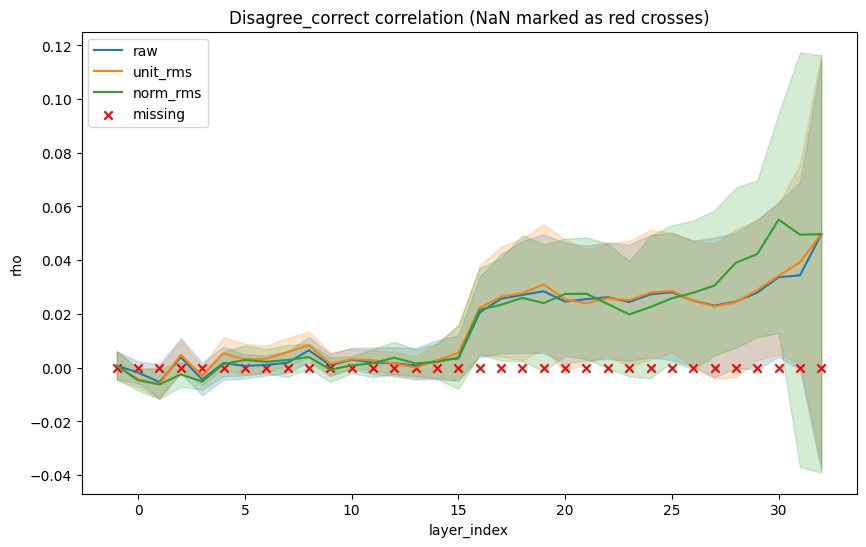

In [35]:
dfp = df_corr_all[df_corr_all["anchor"] == "disagree_correct"]

plt.figure(figsize=(10,6))
sns.lineplot(
    data=dfp.dropna(subset=["rho"]),
    x="layer_index", y="rho",
    hue="mode"
)

# markér manglende lag
missing = dfp[dfp["rho"].isna()]["layer_index"].unique()
plt.scatter(missing, [0]*len(missing), color="red", marker="x", label="missing")
plt.legend()
plt.title("Disagree_correct correlation (NaN marked as red crosses)")
plt.show()


### ==============================================
### Correlation Per Prompt =======================
### ==============================================

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr, kendalltau, pointbiserialr, chi2_contingency
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# ============================================================
# Merge parquet files
# ============================================================
def merge_parquet_files(input_dir: str) -> pd.DataFrame:
    files = sorted(Path(input_dir).glob("*.parquet"))
    if not files:
        raise FileNotFoundError(f"No parquet files found in {input_dir}")

    dfs = []
    for i, f in enumerate(files):
        d = pd.read_parquet(f)
        d["batch_index"] = i
        dfs.append(d)

    df = pd.concat(dfs, ignore_index=True)
    print(f"[merge] merged {len(files)} parquet files → {len(df)} rows")

    n_batches = df["batch_index"].nunique()
    n_prompts = df["prompt_id"].nunique()
    n_pairs = df.groupby(["prompt_id", "batch_index"]).ngroups
    print(f"[diag] unique batch_index={n_batches} | unique prompt_id={n_prompts} | unique (prompt,batch)={n_pairs}")

    if n_pairs < len(files) * 10:
        print("[warn] fewer prompt–batch pairs than expected — possible ID overlap?")
    else:
        print("[ok] prompt–batch pairs look good")

    return df


# ============================================================
# Expand nested top-k metrics 
# ============================================================
def expand_topk_metrics(df, metrics, modes=("raw","unit_rms","norm_rms"), topk_levels=(1,5,10)):
    new_cols=[]
    for metric in metrics:
        for mode in modes:
            base=f"{metric}_{mode}"
            if base not in df.columns:
                continue
            for k in topk_levels:
                new=f"{base}_@{k}"
                df[new]=df[base].apply(
                    lambda d: np.array(d.get(f"@{k}",[]),float)
                    if isinstance(d,dict) and f"@{k}" in d else np.array([])
                )
                new_cols.append(new)
    print(f"[expand] added {len(new_cols)} flattened top-k columns")
    return df


# ============================================================
# Helper
# ============================================================
"""def safe_flatten(x):
    if isinstance(x,(list,np.ndarray)):
        return np.array(x,float).flatten()
    return np.array([],float)"""
def safe_flatten(v):
    """Ensure flattening of nested lists/arrays into 1D np.array."""
    if isinstance(v, (list, np.ndarray)):
        return np.asarray(v, dtype=float).flatten()
    try:
        return np.array([float(v)], dtype=float)
    except Exception:
        return np.array([], dtype=float)

# ============================================================
# Extract anchors 
# ============================================================
def extract_top1_disagreement_anchor(df, modes=("raw","unit_rms","norm_rms")):
    for mode in modes:
        col=f"disagree_correct_{mode}"
        if col not in df.columns:
            print(f"[warn] missing {col}")
            continue
        max_len=int(df[col].apply(
            lambda d: len(d.get("@1",[])) if isinstance(d,dict) else 0
        ).max() or 0)
        def to_array(d):
            if isinstance(d,dict) and "@1" in d:
                arr=np.array(d["@1"],float)
            else:
                arr=np.full(max_len,np.nan)
            return arr
        df[f"{col}_@1"]=df[col].apply(to_array)
        print(f"[ok] normalized {col}_@1 → len={max_len}")
    return df


"""def preprocess_anchors(df, modes=("raw", "unit_rms", "norm_rms")):
    for mode in modes:
        col = f"disagree_correct_{mode}"
        if col not in df.columns:
            print(f"[warn] missing {col}")
            continue

        # find max length
        max_len = int(df[col].apply(
            lambda d: len(d.get("@1", [])) if isinstance(d, dict) else 0
        ).max() or 0)

        def to_array(d):
            if isinstance(d, dict) and "@1" in d:
                arr = np.asarray(d["@1"], dtype=float)
            else:
                arr = np.full(max_len, np.nan, dtype=float)
            if len(arr) < max_len:
                arr = np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan)
            return arr

        df[f"{col}_@1"] = df[col].apply(to_array)
        print(f"[ok] normalized {col}_@1 → len={max_len}")

    for mode in modes:
        col = f"logp_diff_{mode}"
        if col not in df.columns:
            print(f"[warn] missing {col}")
            continue

        def to_array(v):
            if isinstance(v, (list, np.ndarray)):
                return np.asarray(v, dtype=float)
            # fallback for single values
            try:
                return np.array([float(v)], dtype=float)
            except Exception:
                return np.array([np.nan], dtype=float)

        df[col] = df[col].apply(to_array)
        print(f"[ok] flattened {col}")

    print("[done] Anchors preprocessed (binary + continuous)")
    return df"""

def preprocess_anchors(df, modes=("raw", "unit_rms", "norm_rms")):
    # === BINARY ANCHOR ===
    for mode in modes:
        col = f"disagree_correct_{mode}"
        if col not in df.columns:
            print(f"[warn] missing {col}")
            continue

        # find max sequence length (@1-level)
        max_len = int(df[col].apply(
            lambda d: len(d.get("@1", [])) if isinstance(d, dict) else 0
        ).max() or 0)

        def to_array(d):
            if isinstance(d, dict) and "@1" in d:
                arr = np.asarray(d["@1"], dtype=float)
            else:
                arr = np.full(max_len, np.nan, dtype=float)
            # pad to consistent length
            if len(arr) < max_len:
                arr = np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan)
            return arr

        df[f"{col}_@1"] = df[col].apply(to_array)
        print(f"[ok] normalized {col}_@1 → len={max_len}")

    # === CONTINUOUS ANCHOR ===
    for mode in modes:
        col = f"logp_diff_{mode}"
        if col not in df.columns:
            print(f"[warn] missing {col}")
            continue

        # find max length across all prompts
        max_len = int(df[col].apply(
            lambda v: len(v) if isinstance(v, (list, np.ndarray)) else 0
        ).max() or 0)

        def to_array(v):
            if isinstance(v, (list, np.ndarray)):
                arr = np.asarray(v, dtype=float)
            else:
                try:
                    arr = np.array([float(v)], dtype=float)
                except Exception:
                    arr = np.array([np.nan], dtype=float)
            # pad to uniform length
            if len(arr) < max_len:
                arr = np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan)
            return arr

        df[col] = df[col].apply(to_array)
        print(f"[ok] normalized {col} → len={max_len}")

    print("[done] Anchors preprocessed (binary + continuous, unified padding)]")
    return df


# ============================================================
# Correlation 
# ============================================================
def _is_binary(arr, tol=1e-6):
    arr = np.asarray(arr, dtype=float)
    arr = arr[~np.isnan(arr)]
    if len(arr) == 0:
        return False
    u = np.unique(np.round(arr, 6))
    return np.all((np.abs(u - 0) < tol) | (np.abs(u - 1) < tol))


def _phi_coefficient(x, y):
    """Phi coefficient for two binary arrays (0/1)."""
    x, y = np.asarray(x).astype(int), np.asarray(y).astype(int)
    if len(x) == 0 or len(y) == 0:
        return np.nan
    try:
        table = pd.crosstab(x, y)
        if table.shape != (2, 2):
            return np.nan
        chi2, _, _, _ = chi2_contingency(table, correction=False)
        sign = np.sign((table.loc[1, 1] * table.loc[0, 0]) - (table.loc[1, 0] * table.loc[0, 1]))
        return float(sign * np.sqrt(chi2 / len(x)))
    except Exception:
        return np.nan


# --- Deterministic metric-type mapping ---
METRIC_TYPES = {
    # Binary accuracy/agreement
    **{f"acc_A_@{k}": "binary" for k in [1, 5, 10]},
    **{f"acc_B_@{k}": "binary" for k in [1, 5, 10]},
    "disagree_correct": "binary",
    "agree_correct": "binary",
    "agree_wrong": "binary",
    "agree_set": "binary",
    "disagree_set": "binary",

    # Jaccard: only @1 is expected to be binary
    "jaccard_@1": "binary",
    "jaccard_@5": "continuous",
    "jaccard_@10": "continuous",

    # Rest treated as continuous by default
}


def _choose_corr_func_fixed(anchor, metric):
    """Deterministic correlation type based on known data nature."""
    anchor_t = "binary" if "disagree_correct" in anchor else "continuous"
    metric_t = METRIC_TYPES.get(metric, "continuous")

    if anchor_t == "binary" and metric_t == "binary":
        return "phi", _phi_coefficient
    elif anchor_t == "binary" or metric_t == "binary":
        return "pointbiserial", pointbiserialr
    else:
        return "spearman", spearmanr


# ============================================================
# Correlation (per-prompt)
# ============================================================
def correlate_layers_by_anchor_perprompt(
    df,
    anchor,
    metrics,
    modes=("raw", "unit_rms", "norm_rms"),
    topk_levels=(1, 5, 10),
    n_boot=10,
    n_perm=10,
    seed=42,
    output_dir=None,
    model="m_8bit",
    min_valid=3,
):
    np.random.seed(seed)
    results = []
    df_out = df[df["layer_name"].str.lower() == "output"]

    # --- Build anchor map from output layer ---
    anchor_map = {}
    for _, row in df_out.iterrows():
        key = (int(row["prompt_id"]), int(row.get("batch_index", 0)))
        anchor_vecs = {}
        for mode in modes:
            col1 = f"{anchor}_{mode}_@1"
            col2 = f"{anchor}_{mode}"
            col = col1 if col1 in df.columns else col2
            val = row.get(col)
            if isinstance(val, (list, np.ndarray)) and len(val) > 0:
                anchor_vecs[mode] = np.array(val, float)
        if anchor_vecs:
            anchor_map[key] = anchor_vecs
    print(f"[anchor_map] built {len(anchor_map)} anchors")

    skip_const = 0
    SHARED_METRICS = {"cosine_sim", "l2_dist"}

    # --- Main correlation loop ---
    for mode in modes:
        for (lname, lidx), layer_df in tqdm(
            df.groupby(["layer_name", "layer_index"]),
            desc=f"{anchor}_{mode}"
        ):
            for metric in metrics:
                is_topk_only = metric in {"acc_A", "acc_B", "jaccard"}
                suffixes = [f"_@{k}" for k in topk_levels] if is_topk_only else [""] + [f"_@{k}" for k in topk_levels]

                for suffix in suffixes:
                    src_mode = "raw" if metric in SHARED_METRICS else mode
                    mcol = f"{metric}_{src_mode}{suffix}"
                    if mcol not in layer_df.columns:
                        continue

                    per_prompt_rhos, per_prompt_ns = [], []

                    for (pid, bid), group in layer_df.groupby(["prompt_id", "batch_index"]):
                        key = (int(pid), int(bid))
                        if key not in anchor_map or mode not in anchor_map[key]:
                            continue

                        a = anchor_map[key][mode]
                        m = safe_flatten(group[mcol].iloc[0])
                        n = min(len(a), len(m))
                        if n < min_valid:
                            continue

                        a, m = a[:n], m[:n]
                        mask = np.isfinite(a) & np.isfinite(m)
                        n_used = int(mask.sum())
                        if n_used < min_valid:
                            continue

                        if np.std(a[mask]) == 0 or np.std(m[mask]) == 0:
                            skip_const += 1
                            continue

                        cname, corr_func = _choose_corr_func_fixed(anchor, f"{metric}{suffix}")

                        try:
                            if cname == "phi":
                                rho = corr_func(a[mask], m[mask])
                            else:
                                rho, _ = corr_func(a[mask], m[mask])
                        except Exception:
                            rho = np.nan

                        if np.isfinite(rho):
                            per_prompt_rhos.append(rho)
                            per_prompt_ns.append(n_used)

                    # --- Handle missing prompts ---
                    if not per_prompt_rhos:
                        results.append({
                            "mode": mode,
                            "anchor": anchor,
                            "metric": metric + suffix,
                            "corr_type": "undefined",
                            "layer_name": lname,
                            "layer_index": lidx,
                            "rho": np.nan,
                            "rho_boot_median": np.nan,
                            "ci_low": np.nan,
                            "ci_high": np.nan,
                            "p_perm": np.nan,
                            "n_prompts": 0,
                            "n_used_mean": np.nan,
                            "n_used_median": np.nan,
                            "pooling": "per_prompt"
                        })
                        continue

                    # --- Aggregate correlations across prompts ---
                    A = np.array(per_prompt_rhos)
                    N = np.array(per_prompt_ns)
                    rho = np.average(A, weights=N) if len(N) > 0 else np.nan
                    
                    """z = np.arctanh(A)            # Fisher transform
                    rho = np.tanh(np.average(z, weights=N))"""

                    n_mean, n_median = np.nanmean(N), np.nanmedian(N)

                    # --- Bootstrap CI ---
                    if len(A) >= min_valid:
                        boot_rhos = []
                        for _ in range(n_boot):
                            idx = np.random.choice(len(A), len(A), replace=True)
                            boot_rhos.append(np.average(A[idx], weights=N[idx]))
                        if len(boot_rhos) > 20:
                            ci_low, ci_high = np.percentile(boot_rhos, [2.5, 97.5])
                            rho_boot = np.median(boot_rhos)
                        else:
                            ci_low = ci_high = rho_boot = np.nan
                    else:
                        ci_low = ci_high = rho_boot = np.nan

                    # --- Permutation test ---
                    if len(A) >= min_valid:
                        perm_rhos = []
                        for _ in range(n_perm):
                            perm_rhos.append(np.average(np.random.permutation(A), weights=N))
                        if len(perm_rhos) > 20:
                            perm_rhos = np.array(perm_rhos)
                            p_perm = (np.sum(np.abs(perm_rhos) >= abs(rho)) + 1) / (len(perm_rhos) + 1)
                        else:
                            p_perm = np.nan
                    else:
                        p_perm = np.nan

                    # --- Save results ---
                    results.append({
                        "mode": mode,
                        "anchor": anchor,
                        "metric": metric + suffix,
                        "corr_type": cname,
                        "layer_name": lname,
                        "layer_index": lidx,
                        "rho": rho,
                        "rho_boot_median": rho_boot,
                        "ci_low": ci_low,
                        "ci_high": ci_high,
                        "p_perm": p_perm,
                        "n_prompts": len(A),
                        "n_used_mean": n_mean,
                        "n_used_median": n_median,
                        "pooling": "per_prompt"
                    })

    # --- Final output ---
    df_corr = pd.DataFrame(results)
    print(f"[ok] {anchor} → {len(df_corr)} per-prompt correlations")
    print(f"[NaN correlations: {df_corr['rho'].isna().sum()}]")
    print(f"[skipped constant={skip_const}]")

    if output_dir:
        out_path = Path(output_dir) / f"lw_{model}_{anchor}_corr_perprompt.csv"
        df_corr.to_csv(out_path, index=False)
        print(f"[saved per-prompt correlations] {out_path}")

    return df_corr

# ============================================================
# summarize_correlations_perprompt (fix for single-row groups)
# ============================================================
def summarize_correlations_perprompt(df_corr, output_dir, model, ci_mode="both"):
    df = df_corr.dropna(subset=["rho"]).copy()
    if "n" not in df.columns:
        df["n"] = 1
    df["z"] = np.arctanh(np.clip(df["rho"], -0.999999, 0.999999))

    drop_cols = [c for c in ["prompt_id", "batch_index"] if c in df.columns]
    if drop_cols:
        df = df.drop(columns=drop_cols)

    group_cols = ["mode", "anchor", "metric", "corr_type", "layer_name", "layer_index"]

    def _weighted_stats(g):
        out = {}
        if len(g) < 2:
            out["rho_mean"] = g["rho"].iloc[0]
            out["rho_low"] = out["rho_high"] = g["rho"].iloc[0]
            out["rho_boot_mean"] = g["rho_boot_median"].iloc[0]
            out["ci_low_emp"] = out["ci_high_emp"] = np.nan
            out["n_total"] = g["n"].sum()
            for k in group_cols:
                out[k] = g[k].iloc[0]
            return pd.DataFrame([out])

        w = g["n"]
        z = np.arctanh(np.clip(g["rho"], -0.999999, 0.999999))
        z_mean = np.average(z, weights=w)
        z_std = np.sqrt(np.average((z - z_mean)**2, weights=w))
        out["rho_mean"] = np.tanh(z_mean)
        out["rho_low"] = np.tanh(z_mean - 1.96 * z_std)
        out["rho_high"] = np.tanh(z_mean + 1.96 * z_std)
        out["n_total"] = g["n"].sum()

        out["rho_boot_mean"] = np.average(g["rho_boot_median"], weights=w)
        out["ci_low_emp"] = np.average(g["ci_low"], weights=w)
        out["ci_high_emp"] = np.average(g["ci_high"], weights=w)

        for k in group_cols:
            out[k] = g[k].iloc[0]
        return pd.DataFrame([out])

    df_summary = pd.concat(
        [_weighted_stats(g) for _, g in df.groupby(group_cols, group_keys=False)],
        ignore_index=True
    )

    if ci_mode in ("empirical", "both"):
        df_summary["rho_low_plot"] = df_summary["ci_low_emp"]
        df_summary["rho_high_plot"] = df_summary["ci_high_emp"]
    else:
        df_summary["rho_low_plot"] = df_summary["rho_low"]
        df_summary["rho_high_plot"] = df_summary["rho_high"]

    out_summary = Path(output_dir) / f"lw_{model}_corr_perprompt_summary_{ci_mode}.csv"
    df_summary.to_csv(out_summary, index=False)
    print(f"[saved summary] {out_summary}")
    print(f"[diag] rows={len(df_summary)}  groups={df[group_cols].drop_duplicates().shape[0]}")
    return df_summary



# ============================================================
# Run per-prompt correlation pipeline
# ============================================================
BASE = Path("saved_data")
model = "m_quant"
output_dir = BASE / "summary" / model
output_dir.mkdir(parents=True, exist_ok=True)

topk_dir = BASE / "topk" / model
df_topk = merge_parquet_files(topk_dir)
df_topk = expand_topk_metrics(
    df_topk,
    metrics=["jaccard", "acc_A", "acc_B", "disagree_correct"],
    modes=("raw", "unit_rms", "norm_rms")
)
df_topk = preprocess_anchors(df_topk)

for m in ["cosine_sim", "l2_dist"]:
    if f"{m}_raw" in df_topk.columns:
        for mode in ["unit_rms", "norm_rms"]:
            col_src = f"{m}_raw"
            col_dst = f"{m}_{mode}"
            if col_dst not in df_topk.columns:
                df_topk[col_dst] = df_topk[col_src]
                print(f"[copy] propagated {col_src} → {col_dst}")

anchors = ["disagree_correct", "logp_diff"]
metrics = [
    "kl_ab", "kl_ba", "js_div", "js_dist", "tvd",
    "entropy_A", "entropy_B", "cosine_sim", "l2_dist",
    "ppl_diff", "jaccard", "acc_A", "acc_B"
]

df_corr_perprompt_all = []
for a in anchors:
    df_corr_perprompt_all.append(
        correlate_layers_by_anchor_perprompt(df_topk, a, metrics, model=model)
    )
df_corr_perprompt_all = pd.concat(df_corr_perprompt_all, ignore_index=True)

perprompt_corr_path = output_dir / f"lw_{model}_corr_perprompt.csv"
perprompt_summary_path = output_dir / f"lw_{model}_corr_perprompt_summary.csv"

df_corr_perprompt_all.to_csv(perprompt_corr_path, index=False)
print(f"[saved per-prompt correlations] {perprompt_corr_path}")

df_summary_pp = summarize_correlations_perprompt(df_corr_perprompt_all, output_dir=output_dir, model=model)
print(f"[saved per-prompt summary] {perprompt_summary_path}")


[merge] merged 50 parquet files → 17000 rows
[diag] unique batch_index=50 | unique prompt_id=10 | unique (prompt,batch)=500
[ok] prompt–batch pairs look good
[expand] added 36 flattened top-k columns
[ok] normalized disagree_correct_raw_@1 → len=15
[ok] normalized disagree_correct_unit_rms_@1 → len=15
[ok] normalized disagree_correct_norm_rms_@1 → len=15
[ok] normalized logp_diff_raw → len=15
[ok] normalized logp_diff_unit_rms → len=15
[ok] normalized logp_diff_norm_rms → len=15
[done] Anchors preprocessed (binary + continuous, unified padding)]
[anchor_map] built 500 anchors


disagree_correct_norm_rms: 100%|██████████| 34/34 [02:15<00:00,  4.00s/it]


[ok] disagree_correct → 1938 per-prompt correlations
[NaN correlations: 111]
[skipped constant=291515]
[anchor_map] built 500 anchors


logp_diff_norm_rms: 100%|██████████| 34/34 [01:10<00:00,  2.08s/it]


[ok] logp_diff → 1938 per-prompt correlations
[NaN correlations: 111]
[skipped constant=237054]
[saved per-prompt correlations] saved_data/summary/m_quant/lw_m_quant_corr_perprompt.csv
[saved summary] saved_data/summary/m_quant/lw_m_quant_corr_perprompt_summary_both.csv
[diag] rows=3654  groups=3654
[saved per-prompt summary] saved_data/summary/m_quant/lw_m_quant_corr_perprompt_summary.csv


In [9]:
df_corr_perprompt_all.query("metric.str.contains('cosine_sim')").groupby("mode")["rho"].mean()


mode
norm_rms   -0.034492
raw        -0.034492
unit_rms   -0.034492
Name: rho, dtype: float64

In [10]:
df_corr_perprompt_all

,mode,anchor,metric,corr_type,layer_name,layer_index,rho,rho_boot_median,ci_low,ci_high,p_perm,n_prompts,n_used_mean,n_used_median,pooling
0,raw,disagree_correct,kl_ab,pointbiserial,embed_tokens,-1,0.046042,NaN,NaN,NaN,NaN,77,10.935065,10.0,per_prompt
1,raw,disagree_correct,kl_ba,pointbiserial,embed_tokens,-1,-0.051954,NaN,NaN,NaN,NaN,77,10.935065,10.0,per_prompt
2,raw,disagree_correct,js_div,pointbiserial,embed_tokens,-1,0.018521,NaN,NaN,NaN,NaN,77,10.935065,10.0,per_prompt
3,raw,disagree_correct,js_dist,pointbiserial,embed_tokens,-1,0.014579,NaN,NaN,NaN,NaN,77,10.935065,10.0,per_prompt
4,raw,disagree_correct,tvd,pointbiserial,embed_tokens,-1,-0.014360,NaN,NaN,NaN,NaN,77,10.935065,10.0,per_prompt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871,norm_rms,logp_diff,acc_A_@5,pointbiserial,output,32,0.192738,NaN,NaN,NaN,NaN,500,10.088000,10.0,per_prompt
3872,norm_rms,logp_diff,acc_A_@10,pointbiserial,output,32,0.215255,NaN,NaN,NaN,NaN,500,10.088000,10.0,per_prompt
3873,norm_rms,logp_diff,acc_B_@1,pointbiserial,output,32,0.092933,NaN,NaN,NaN,NaN,494,10.107287,10.0,per_prompt
3874,norm_rms,logp_diff,acc_B_@5,pointbiserial,output,32,0.161631,NaN,NaN,NaN,NaN,500,10.088000,10.0,per_prompt


In [11]:
df_summary_pp

,rho_mean,rho_low,rho_high,rho_boot_mean,ci_low_emp,ci_high_emp,n_total,mode,anchor,metric,corr_type,layer_name,layer_index,rho_low_plot,rho_high_plot
0,-0.071429,-0.071429,-0.071429,NaN,NaN,NaN,1,norm_rms,disagree_correct,acc_A_@1,phi,layer.11,11,NaN,NaN
1,-0.076923,-0.076923,-0.076923,NaN,NaN,NaN,1,norm_rms,disagree_correct,acc_A_@1,phi,layer.12,12,NaN,NaN
2,-0.071429,-0.071429,-0.071429,NaN,NaN,NaN,1,norm_rms,disagree_correct,acc_A_@1,phi,layer.13,13,NaN,NaN
3,-0.071429,-0.071429,-0.071429,NaN,NaN,NaN,1,norm_rms,disagree_correct,acc_A_@1,phi,layer.14,14,NaN,NaN
4,-0.096822,-0.096822,-0.096822,NaN,NaN,NaN,1,norm_rms,disagree_correct,acc_A_@1,phi,layer.15,15,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3525,0.006513,0.006513,0.006513,NaN,NaN,NaN,1,unit_rms,logp_diff,tvd,spearman,layer.6,6,NaN,NaN
3526,0.026021,0.026021,0.026021,NaN,NaN,NaN,1,unit_rms,logp_diff,tvd,spearman,layer.7,7,NaN,NaN
3527,0.031489,0.031489,0.031489,NaN,NaN,NaN,1,unit_rms,logp_diff,tvd,spearman,layer.8,8,NaN,NaN
3528,0.043021,0.043021,0.043021,NaN,NaN,NaN,1,unit_rms,logp_diff,tvd,spearman,layer.9,9,NaN,NaN


In [12]:
df_corr_perprompt_all.isna().sum()

mode                  0
anchor                0
metric                0
corr_type             0
layer_name            0
layer_index           0
rho                 346
rho_boot_median    3876
ci_low             3876
ci_high            3876
p_perm             3876
n_prompts             0
n_used_mean         346
n_used_median       346
pooling               0
dtype: int64

In [13]:
df_summary_pp.isna().sum()

rho_mean            0
rho_low             0
rho_high            0
rho_boot_mean    3530
ci_low_emp       3530
ci_high_emp      3530
n_total             0
mode                0
anchor              0
metric              0
corr_type           0
layer_name          0
layer_index         0
rho_low_plot     3530
rho_high_plot    3530
dtype: int64

In [7]:
df_raw = pd.read_csv("saved_data/summary/m_8bit/lw_m_8bit_corr_perprompt.csv")
df_sum = pd.read_csv("saved_data/summary/m_8bit/lw_m_8bit_corr_perprompt_summary_both.csv")

merged = df_sum.merge(df_raw, on=["mode","anchor","metric","corr_type","layer_index"], suffixes=("_sum","_raw"))
merged["diff"] = merged["rho_mean"] - merged["rho"]

print(merged["diff"].abs().mean())

1.6214142087001617e-18


In [9]:
df_raw = pd.read_csv("saved_data/summary/m_8bit/lw_m_8bit_corr_pooled.csv")
df_sum = pd.read_csv("saved_data/summary/m_8bit/lw_m_8bit_corr_pooled_summary_both.csv")

merged = df_sum.merge(df_raw, on=["mode","anchor","metric","corr_type","layer_index"], suffixes=("_sum","_raw"))
merged["diff"] = merged["rho_mean"] - merged["rho"]

print(merged["diff"].abs().mean())

1.3645738272361821e-18


In [27]:
import pandas as pd
from pathlib import Path

BASE_DIR = Path("saved_data/summary")
MODELS = ["m_4bit", "m_8bit", "m_quant"]

dfs = []
for model in MODELS:
    model_dir = BASE_DIR / model
    if not model_dir.exists():
        continue
    for f in model_dir.glob("*_summary*.csv"): 
        d = pd.read_csv(f)
        d["model"] = model
        if "pooled" in f.stem:
            d["pooling"] = "pooled"
        elif "perprompt" in f.stem or "per_prompt" in f.stem:
            d["pooling"] = "per_prompt"
        else:
            d["pooling"] = "unknown"
        dfs.append(d)

df = pd.concat(dfs, ignore_index=True)
print(f"[ok] merged {len(df)} rows from {df['model'].nunique()} models.")


[ok] merged 7512 rows from 1 models.


In [28]:
print("\nUnique layers per model:")
for model in df["model"].unique():
    layers = sorted(df[df["model"] == model]["layer_index"].unique())
    print(f"{model}: {layers[:10]}... ({len(layers)} layers total)")



Unique layers per model:
m_quant: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]... (34 layers total)


In [14]:
for model in ["m_4bit", "m_8bit", "m_quant"]:
    dsub = df[df["model"] == model]
    missing = dsub["rho_mean"].isna().sum()
    total = len(dsub)
    print(f"{model}: {missing}/{total} rows have NaN rho_mean ({missing/total:.1%})")

m_4bit: 0/9213 rows have NaN rho_mean (0.0%)
m_8bit: 0/9242 rows have NaN rho_mean (0.0%)
m_quant: 0/9468 rows have NaN rho_mean (0.0%)


In [15]:
df_per = df[df["pooling"] == "per_prompt"]

print("\n[PER-PROMPT] Rows per model:")
print(df_per["model"].value_counts())

print("\nUnique layers per model (per-prompt only):")
for model in df_per["model"].unique():
    layers = sorted(df_per[df_per["model"] == model]["layer_index"].unique())
    print(f"{model}: {layers[:10]}... ({len(layers)} total layers)")


[PER-PROMPT] Rows per model:
model
m_quant    3570
m_8bit     3368
m_4bit     3333
Name: count, dtype: int64

Unique layers per model (per-prompt only):
m_4bit: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]... (34 total layers)
m_8bit: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]... (34 total layers)
m_quant: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]... (34 total layers)


In [16]:
for model in ["m_4bit", "m_8bit"]:
    dsub = df_per[df_per["model"] == model]
    low_layers = dsub[dsub["layer_index"] < 4] 
    print(f"\n{model} — mean rho_mean for early layers:")
    print(low_layers.groupby("layer_index")["rho_mean"].mean().round(4))


m_4bit — mean rho_mean for early layers:
layer_index
-1    0.0257
 0    0.0129
 1    0.0053
 2    0.0115
 3   -0.0112
Name: rho_mean, dtype: float64

m_8bit — mean rho_mean for early layers:
layer_index
-1    0.0154
 0    0.0031
 1   -0.0032
 2    0.0064
 3   -0.0030
Name: rho_mean, dtype: float64


In [17]:
import pandas as pd
from pathlib import Path

BASE_DIR = Path("saved_data/summary")
MODELS = ["m_4bit", "m_8bit", "m_quant"]

dfs = []
for model in MODELS:
    for f in (BASE_DIR / model).glob("*_summary*.csv"):
        d = pd.read_csv(f)
        d["model"] = model
        if "pooled" in f.stem:
            d["pooling"] = "pooled"
        elif "perprompt" in f.stem or "per_prompt" in f.stem:
            d["pooling"] = "per_prompt"
        else:
            d["pooling"] = "unknown"
        dfs.append(d)

df = pd.concat(dfs, ignore_index=True)

for pooling in ["pooled", "per_prompt"]:
    print(f"\n=== {pooling.upper()} ===")
    d = df[df["pooling"] == pooling]
    all_layers = sorted(df["layer_index"].unique())
    print(f"Alle mulige lag: {all_layers[:10]}... ({len(all_layers)} total)")
    for model in MODELS:
        layers = sorted(d[d["model"] == model]["layer_index"].unique())
        missing = sorted(set(all_layers) - set(layers))
        print(f"{model}: {len(layers)} lag fundet, mangler {len(missing)} → {missing[:10] if missing else 'ingen mangler'}")



=== POOLED ===
Alle mulige lag: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]... (34 total)
m_4bit: 34 lag fundet, mangler 0 → ingen mangler
m_8bit: 34 lag fundet, mangler 0 → ingen mangler
m_quant: 34 lag fundet, mangler 0 → ingen mangler

=== PER_PROMPT ===
Alle mulige lag: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]... (34 total)
m_4bit: 34 lag fundet, mangler 0 → ingen mangler
m_8bit: 34 lag fundet, mangler 0 → ingen mangler
m_quant: 34 lag fundet, mangler 0 → ingen mangler


In [18]:
subset = df[
    (df["model"] == "m_8bit") &
    (df["pooling"] == "per_prompt") &
    (df["anchor"] == "logp_diff") &
    (df["metric"] == "kl_ab") &
    (df["corr_type"] == "spearman")
]

print("Lag til stede:", sorted(subset["layer_index"].unique()))
print("Antal lag:", subset["layer_index"].nunique())


Lag til stede: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32)]
Antal lag: 34


In [19]:
subset = df[
    (df["anchor"] == "disagree_correct") &
    (df["corr_type"] == "pointbiserial")
]

print("Unique layers per model (per_prompt):")
for model in df["model"].unique():
    d = subset[(subset["model"] == model) & (df["pooling"] == "per_prompt")]
    print(f"{model}: {sorted(d['layer_index'].unique())[:10]} ... total {d['layer_index'].nunique()}")


Unique layers per model (per_prompt):
m_4bit: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)] ... total 34
m_8bit: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)] ... total 34
m_quant: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)] ... total 34


/tmp/ipykernel_6961/2016669249.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d = subset[(subset["model"] == model) & (df["pooling"] == "per_prompt")]
/tmp/ipykernel_6961/2016669249.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d = subset[(subset["model"] == model) & (df["pooling"] == "per_prompt")]
/tmp/ipykernel_6961/2016669249.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d = subset[(subset["model"] == model) & (df["pooling"] == "per_prompt")]


# ==============================================
# Plot TopK Correlations =======================
# ==============================================

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === STYLE ===
sns.set_theme(style="whitegrid", context="talk", palette="deep")
plt.rcParams.update({
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# === CONFIG ===
BASE_DIR = Path("saved_data/summary")
MODELS = ["m_4bit", "m_8bit", "m_quant"]
ANCHORS_CONTINUOUS = ["logp_diff"]
ANCHORS_BINARY = ["disagree_correct"]
OUT_ROOT = Path("saved_data/figures_rawcorr_all")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

LAYOUT_MODE = "metric"   # "mode" | "metric" | "group"

SPEARMAN_METRICS = [
    "tvd","kl_ab","kl_ba","js_div","js_dist","cosine_sim",
    "l2_dist","ppl_diff","jaccard_@1","jaccard_@5","jaccard_@10"
]
BISERIAL_METRICS = [
    "acc_A_@1","acc_A_@5","acc_A_@10",
    "acc_B_@1","acc_B_@5","acc_B_@10",
    "disagree_correct","jaccard_@1","jaccard_@5","jaccard_@10"
]
GROUPS = {
    "divergence": ["tvd","kl_ab","kl_ba","js_div","js_dist","ppl_diff"],
    "representation": ["cosine_sim","l2_dist","jaccard_@1","jaccard_@5","jaccard_@10"],
    "accuracy": ["acc_A_@1","acc_B_@1","acc_A_@5","acc_B_@5","disagree_correct"]
}

# === LOAD RAW CORR FILES ===
dfs = []
for model in MODELS:
    model_dir = BASE_DIR / model
    if not model_dir.exists():
        continue
    for f in model_dir.glob("*corr_*.csv"):
        if "summary" in f.name:
            continue
        d = pd.read_csv(f)
        d["model"] = model
        if "pooled" in f.stem:
            d["pooling"] = "pooled"
        elif "perprompt" in f.stem or "per_prompt" in f.stem:
            d["pooling"] = "per_prompt"
        else:
            d["pooling"] = "unknown"
        dfs.append(d)

if not dfs:
    raise RuntimeError("No raw correlation files found!")

df = pd.concat(dfs, ignore_index=True)
for c in ["rho"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["layer_index"] = pd.to_numeric(df["layer_index"], errors="coerce").fillna(0).astype(int)
df["rho_smooth"] = df["rho"]  # raw values only

print(f"[ok] merged {len(df)} rows from {df['model'].nunique()} models.")
print(df.groupby(["anchor","corr_type","pooling"])["rho"].describe().round(3))

# === HELPERS ===
def _auto_subplots(n_items, n_cols=3):
    n_rows = int(np.ceil(n_items / n_cols))
    return n_rows, n_cols

def _finalize_grid(fig, axes, title, save_path=None):
    for ax in axes.flat:
        if not ax.has_data():
            ax.axis("off")
    fig.suptitle(title, fontsize=15, weight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path:
        fig.savefig(save_path, dpi=250, bbox_inches="tight")
        print(f"[saved] {save_path}")
    plt.close(fig)

def _mark_nans(ax, dsub):
    d_nan = dsub[dsub["rho"].isna()]
    if not d_nan.empty:
        for i, model in enumerate(sorted(d_nan["model"].unique())):
            d_m = d_nan[d_nan["model"] == model]
            ax.scatter(
                d_m["layer_index"],
                [-0.95 + 0.05*i] * len(d_m),
                color="red", marker="x", s=50, label=f"{model} NaN"
            )

# === PLOT FUNCTIONS ===
def plot_by_mode(df_sub, corr_type, anchor, pooling, out_dir):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for ax, mode in zip(axes, ["raw", "unit_rms", "norm_rms"]):
        dmode = df_sub[df_sub["mode"] == mode]
        if dmode.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=11)
            continue
        sns.lineplot(
            data=dmode, x="layer_index", y="rho_smooth",
            hue="model", style="metric", lw=2, ax=ax
        )
        _mark_nans(ax, dmode)
        ax.axhline(0, color="black", linestyle=":")
        ax.axhline(0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
        ax.axhline(-0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
        ax.set_ylim(-1, 1)
        ax.set_title(mode.upper(), fontsize=12, weight="bold")
        ax.set_xlabel("Layer index")
        ax.set_ylabel("ρ" if mode == "raw" else "")
        ax.legend(fontsize=8)
    _finalize_grid(fig, axes, f"{corr_type.capitalize()} — {anchor} ({pooling})",
                   out_dir / f"{corr_type}_{anchor}_{pooling}_modes.png")

def plot_by_metric(df_sub, corr_type, anchor, pooling, out_dir, n_cols=3):
    metrics = sorted(df_sub["metric"].unique())
    n_rows, n_cols = _auto_subplots(len(metrics), n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 3.5 * n_rows), sharey=True)
    axes = np.array(axes).reshape(-1)
    for ax, metric in zip(axes, metrics):
        dmet = df_sub[df_sub["metric"] == metric]
        if dmet.empty:
            continue
        sns.lineplot(
            data=dmet, x="layer_index", y="rho_smooth",
            hue="model", style="mode", lw=2.2, ax=ax
        )
        _mark_nans(ax, dmet)
        ax.axhline(0, color="black", linestyle=":")
        ax.axhline(0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
        ax.axhline(-0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
        ax.set_ylim(-1, 1)
        ax.set_title(metric, fontsize=10)
        ax.set_xlabel("Layer index")
        ax.set_ylabel("ρ")
        ax.legend(fontsize=8, frameon=True)
    _finalize_grid(fig, axes, f"{corr_type.capitalize()} — {anchor} ({pooling})",
                   out_dir / f"{corr_type}_{anchor}_{pooling}_metrics.png")

def plot_by_group(df_sub, corr_type, anchor, pooling, out_dir):
    for gname, gmetrics in GROUPS.items():
        dgroup = df_sub[df_sub["metric"].isin(gmetrics)]
        if dgroup.empty:
            continue
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
        for ax, mode in zip(axes, ["raw", "unit_rms", "norm_rms"]):
            dmode = dgroup[dgroup["mode"] == mode]
            if dmode.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=11)
                continue
            sns.lineplot(
                data=dmode, x="layer_index", y="rho_smooth",
                hue="model", style="metric", lw=2, ax=ax
            )
            _mark_nans(ax, dmode)
            ax.axhline(0, color="black", linestyle=":")
            ax.axhline(0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
            ax.axhline(-0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
            ax.set_ylim(-1, 1)
            ax.set_title(f"{gname.title()} ({mode})", fontsize=11)
            ax.set_xlabel("Layer index")
            ax.set_ylabel("ρ" if mode == "raw" else "")
            ax.legend(fontsize=8, frameon=True)
        _finalize_grid(fig, axes,
                       f"{gname.capitalize()} — {corr_type.capitalize()} ({anchor}/{pooling})",
                       out_dir / f"{corr_type}_{anchor}_{pooling}_{gname}.png")

# === MAIN LOOP ===
for pooling in ["pooled", "per_prompt"]:
    out_dir = OUT_ROOT / pooling
    out_dir.mkdir(parents=True, exist_ok=True)

    # Continuous (Spearman)
    for anchor in ANCHORS_CONTINUOUS:
        df_s = df[
            (df["anchor"] == anchor)
            & (df["corr_type"] == "spearman")
            & (df["pooling"] == pooling)
            & (df["metric"].isin(SPEARMAN_METRICS))
        ]
        if df_s.empty:
            continue
        if LAYOUT_MODE == "mode":
            plot_by_mode(df_s, "spearman", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "metric":
            plot_by_metric(df_s, "spearman", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "group":
            plot_by_group(df_s, "spearman", anchor, pooling, out_dir)

    # Binary (Point-biserial & Phi)
    for corr_type in ["pointbiserial", "phi"]:
        for anchor in ANCHORS_BINARY:
            df_b = df[
                (df["anchor"] == anchor)
                & (df["corr_type"] == corr_type)
                & (df["pooling"] == pooling)
                & (df["metric"].isin(BISERIAL_METRICS))
            ]
            if df_b.empty:
                continue
            if LAYOUT_MODE == "mode":
                plot_by_mode(df_b, corr_type, anchor, pooling, out_dir)
            elif LAYOUT_MODE == "metric":
                plot_by_metric(df_b, corr_type, anchor, pooling, out_dir)
            elif LAYOUT_MODE == "group":
                plot_by_group(df_b, corr_type, anchor, pooling, out_dir)

# === MIXED ALL-COMBINATION PLOTS ===
print("\n[mixed plotting] Generating full cross-anchor × metric plots...")

ALL_CORR_TYPES = ["phi", "pointbiserial", "spearman"]

for pooling in ["pooled", "per_prompt"]:
    out_dir = OUT_ROOT / pooling
    out_dir.mkdir(parents=True, exist_ok=True)

    for anchor in ANCHORS_BINARY + ANCHORS_CONTINUOUS:
        df_all = df[
            (df["anchor"] == anchor)
            & (df["pooling"] == pooling)
            & (df["corr_type"].isin(ALL_CORR_TYPES))
        ]
        if df_all.empty:
            print(f"[skip] no data for {anchor} ({pooling})")
            continue

        print(f"[mixed] {anchor} ({pooling}) → {df_all['metric'].nunique()} metrics plotted")
        plot_by_metric(df_all, "mixed_all", anchor, pooling, out_dir)
        plot_by_group(df_all, "mixed_all", anchor, pooling, out_dir)

# === QUICK TOPLIST ===
top = (
    df.groupby(["anchor", "metric", "corr_type", "model"])["rho"]
      .mean().reset_index()
      .sort_values("rho", ascending=False)
)
print("\nTop correlations:")
print(top.head(20).to_string(index=False))


[ok] merged 23160 rows from 3 models.
                                            count   mean    std    min    25%  \
anchor           corr_type     pooling                                          
disagree_correct phi           per_prompt  1857.0  0.018  0.156 -0.864 -0.070   
                               pooled      2094.0  0.012  0.076 -0.529 -0.009   
                 pointbiserial per_prompt  3366.0  0.018  0.087 -0.191 -0.036   
                               pooled      3366.0  0.013  0.070 -0.185 -0.019   
                 undefined     per_prompt     0.0    NaN    NaN    NaN    NaN   
                               pooled         0.0    NaN    NaN    NaN    NaN   
logp_diff        pointbiserial per_prompt  2094.0 -0.018  0.110 -0.328 -0.073   
                               pooled      2094.0 -0.010  0.071 -0.338 -0.020   
                 spearman      per_prompt  3366.0  0.028  0.107 -0.324 -0.020   
                               pooled      3366.0  0.031  0.129 -0.390 

In [3]:
df.query("metric == 'ppl_diff'")[["rho","corr_type","anchor","pooling"]].describe()


,rho
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === STYLE ===
sns.set_theme(style="whitegrid", context="talk", palette="deep")
plt.rcParams.update({
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# === CONFIG ===
BASE_DIR = Path("saved_data/summary")
MODELS = ["m_4bit", "m_8bit", "m_quant"]
ANCHORS_CONTINUOUS = ["logp_diff"]
ANCHORS_BINARY = ["disagree_correct"]
OUT_ROOT = Path("saved_data/figures_rawcorr")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

LAYOUT_MODE = "metric"   # "mode" | "metric" | "group"

SPEARMAN_METRICS = [
    "tvd","kl_ab","kl_ba","js_div","js_dist","cosine_sim",
    "l2_dist","ppl_diff","jaccard_@1","jaccard_@5","jaccard_@10"
]
BISERIAL_METRICS = [
    "acc_A_@1","acc_A_@5","acc_A_@10",
    "acc_B_@1","acc_B_@5","acc_B_@10",
    "disagree_correct","jaccard_@1","jaccard_@5","jaccard_@10"
]
GROUPS = {
    "divergence": ["tvd","kl_ab","kl_ba","js_div","js_dist","ppl_diff"],
    "representation": ["cosine_sim","l2_dist","jaccard_@1","jaccard_@5","jaccard_@10"],
    "accuracy": ["acc_A_@1","acc_B_@1","acc_A_@5","acc_B_@5","disagree_correct"]
}

# === LOAD RAW CORR FILES ===
dfs = []
for model in MODELS:
    model_dir = BASE_DIR / model
    if not model_dir.exists():
        continue
    for f in model_dir.glob("*corr_*.csv"):
        if "summary" in f.name:
            continue
        d = pd.read_csv(f)
        d["model"] = model
        if "pooled" in f.stem:
            d["pooling"] = "pooled"
        elif "perprompt" in f.stem or "per_prompt" in f.stem:
            d["pooling"] = "per_prompt"
        else:
            d["pooling"] = "unknown"
        dfs.append(d)

if not dfs:
    raise RuntimeError("No raw correlation files found!")

df = pd.concat(dfs, ignore_index=True)
for c in ["rho"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["layer_index"] = pd.to_numeric(df["layer_index"], errors="coerce").fillna(0).astype(int)
df["rho_smooth"] = df["rho"]  # raw values only

print(f"[ok] merged {len(df)} rows from {df['model'].nunique()} models.")
print(df.groupby(["anchor","corr_type","pooling"])["rho"].describe().round(3))

# === HELPERS ===
def _auto_subplots(n_items, n_cols=3):
    n_rows = int(np.ceil(n_items / n_cols))
    return n_rows, n_cols

def _finalize_grid(fig, axes, title, save_path=None):
    for ax in axes.flat:
        if not ax.has_data():
            ax.axis("off")
    fig.suptitle(title, fontsize=15, weight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path:
        fig.savefig(save_path, dpi=250, bbox_inches="tight")
        print(f"[saved] {save_path}")
    plt.close(fig)

def _mark_nans(ax, dsub):
    d_nan = dsub[dsub["rho"].isna()]
    if not d_nan.empty:
        for i, model in enumerate(sorted(d_nan["model"].unique())):
            d_m = d_nan[d_nan["model"] == model]
            ax.scatter(
                d_m["layer_index"],
                [-0.95 + 0.05*i] * len(d_m),  # lidt forskudt pr. model
                color="red", marker="x", s=50, label=f"{model} NaN"
            )

# === PLOT FUNCTIONS ===
def plot_by_mode(df_sub, corr_type, anchor, pooling, out_dir):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for ax, mode in zip(axes, ["raw", "unit_rms", "norm_rms"]):
        dmode = df_sub[df_sub["mode"] == mode]
        if dmode.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=11)
            continue
        sns.lineplot(
            data=dmode, x="layer_index", y="rho_smooth",
            hue="model", style="metric", lw=2, ax=ax
        )
        _mark_nans(ax, dmode)
        ax.axhline(0, color="black", linestyle=":")
        ax.axhline(0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
        ax.axhline(-0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
        ax.set_ylim(-1, 1)
        ax.set_title(mode.upper(), fontsize=12, weight="bold")
        ax.set_xlabel("Layer index")
        ax.set_ylabel("ρ" if mode == "raw" else "")
        ax.legend(fontsize=8)
    _finalize_grid(fig, axes, f"{corr_type.capitalize()} — {anchor} ({pooling})",
                   out_dir / f"{corr_type}_{anchor}_{pooling}_modes.png")

def plot_by_metric(df_sub, corr_type, anchor, pooling, out_dir, n_cols=3):
    metrics = sorted(df_sub["metric"].unique())
    n_rows, n_cols = _auto_subplots(len(metrics), n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 3.5 * n_rows), sharey=True)
    axes = np.array(axes).reshape(-1)
    for ax, metric in zip(axes, metrics):
        dmet = df_sub[df_sub["metric"] == metric]
        if dmet.empty:
            continue
        sns.lineplot(
            data=dmet, x="layer_index", y="rho_smooth",
            hue="model", style="mode", lw=2.2, ax=ax
        )
        _mark_nans(ax, dmet)
        ax.axhline(0, color="black", linestyle=":")
        ax.axhline(0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
        ax.axhline(-0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
        ax.set_ylim(-1, 1)
        ax.set_title(metric, fontsize=10)
        ax.set_xlabel("Layer index")
        ax.set_ylabel("ρ")
        ax.legend(fontsize=8, frameon=True)
    _finalize_grid(fig, axes, f"{corr_type.capitalize()} — {anchor} ({pooling})",
                   out_dir / f"{corr_type}_{anchor}_{pooling}_metrics.png")

def plot_by_group(df_sub, corr_type, anchor, pooling, out_dir):
    for gname, gmetrics in GROUPS.items():
        dgroup = df_sub[df_sub["metric"].isin(gmetrics)]
        if dgroup.empty:
            continue
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
        for ax, mode in zip(axes, ["raw", "unit_rms", "norm_rms"]):
            dmode = dgroup[dgroup["mode"] == mode]
            if dmode.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=11)
                continue
            sns.lineplot(
                data=dmode, x="layer_index", y="rho_smooth",
                hue="model", style="metric", lw=2, ax=ax
            )
            _mark_nans(ax, dmode)
            ax.axhline(0, color="black", linestyle=":")
            ax.axhline(0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
            ax.axhline(-0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
            ax.set_ylim(-1, 1)
            ax.set_title(f"{gname.title()} ({mode})", fontsize=11)
            ax.set_xlabel("Layer index")
            ax.set_ylabel("ρ" if mode == "raw" else "")
            ax.legend(fontsize=8, frameon=True)
        _finalize_grid(fig, axes,
                       f"{gname.capitalize()} — {corr_type.capitalize()} ({anchor}/{pooling})",
                       out_dir / f"{corr_type}_{anchor}_{pooling}_{gname}.png")

# === MAIN LOOP ===
for pooling in ["pooled", "per_prompt"]:
    out_dir = OUT_ROOT / pooling
    out_dir.mkdir(parents=True, exist_ok=True)

    # Continuous (Spearman)
    for anchor in ANCHORS_CONTINUOUS:
        df_s = df[
            (df["anchor"] == anchor)
            & (df["corr_type"] == "spearman")
            & (df["pooling"] == pooling)
            & (df["metric"].isin(SPEARMAN_METRICS))
        ]
        if df_s.empty:
            continue
        if LAYOUT_MODE == "mode":
            plot_by_mode(df_s, "spearman", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "metric":
            plot_by_metric(df_s, "spearman", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "group":
            plot_by_group(df_s, "spearman", anchor, pooling, out_dir)

    # Binary (Point-biserial & Phi)
    for corr_type in ["pointbiserial", "phi"]:
        for anchor in ANCHORS_BINARY:
            df_b = df[
                (df["anchor"] == anchor)
                & (df["corr_type"] == corr_type)
                & (df["pooling"] == pooling)
                & (df["metric"].isin(BISERIAL_METRICS))
            ]
            if df_b.empty:
                continue
            if LAYOUT_MODE == "mode":
                plot_by_mode(df_b, corr_type, anchor, pooling, out_dir)
            elif LAYOUT_MODE == "metric":
                plot_by_metric(df_b, corr_type, anchor, pooling, out_dir)
            elif LAYOUT_MODE == "group":
                plot_by_group(df_b, corr_type, anchor, pooling, out_dir)

# === QUICK TOPLIST ===
top = (
    df.groupby(["anchor", "metric", "corr_type", "model"])["rho"]
      .mean().reset_index()
      .sort_values("rho", ascending=False)
)
print("\nTop correlations:")
print(top.head(20).to_string(index=False))


[ok] merged 23160 rows from 3 models.
                                            count   mean    std    min    25%  \
anchor           corr_type     pooling                                          
disagree_correct phi           per_prompt  1857.0  0.018  0.156 -0.864 -0.070   
                               pooled      2094.0  0.012  0.076 -0.529 -0.009   
                 pointbiserial per_prompt  3366.0  0.018  0.087 -0.191 -0.036   
                               pooled      3366.0  0.013  0.070 -0.185 -0.019   
                 undefined     per_prompt     0.0    NaN    NaN    NaN    NaN   
                               pooled         0.0    NaN    NaN    NaN    NaN   
logp_diff        pointbiserial per_prompt  2094.0 -0.018  0.110 -0.328 -0.073   
                               pooled      2094.0 -0.010  0.071 -0.338 -0.020   
                 spearman      per_prompt  3366.0  0.028  0.107 -0.324 -0.020   
                               pooled      3366.0  0.031  0.129 -0.390 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === STYLE ===
sns.set_theme(style="whitegrid", context="talk", palette="deep")
plt.rcParams.update({
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# === CONFIG ===
BASE_DIR = Path("saved_data/summary")
MODELS = ["m_4bit", "m_8bit", "m_quant"]
ANCHORS_CONTINUOUS = ["logp_diff"]
ANCHORS_BINARY = ["disagree_correct"]
OUT_ROOT = Path("saved_data/figures_flexible_rawcorr")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

LAYOUT_MODE = "metric"   # "mode" | "metric" | "group"

SPEARMAN_METRICS = [
    "tvd","kl_ab","kl_ba","js_div","js_dist","cosine_sim",
    "l2_dist","ppl_diff","jaccard_@1","jaccard_@5","jaccard_@10"
]
BISERIAL_METRICS = [
    "acc_A_@1","acc_A_@5","acc_A_@10",
    "acc_B_@1","acc_B_@5","acc_B_@10",
    "disagree_correct","jaccard_@1","jaccard_@5","jaccard_@10"
]
GROUPS = {
    "divergence": ["tvd","kl_ab","kl_ba","js_div","js_dist","ppl_diff"],
    "representation": ["cosine_sim","l2_dist","jaccard_@1","jaccard_@5","jaccard_@10"],
    "accuracy": ["acc_A_@1","acc_B_@1","acc_A_@5","acc_B_@5","disagree_correct"]
}

# === LOAD RAW CORR FILES ===
dfs = []
for model in MODELS:
    model_dir = BASE_DIR / model
    if not model_dir.exists():
        continue
    for f in model_dir.glob("*corr_*.csv"):
        if "summary" in f.name:
            continue
        d = pd.read_csv(f)
        d["model"] = model
        if "pooled" in f.stem:
            d["pooling"] = "pooled"
        elif "perprompt" in f.stem or "per_prompt" in f.stem:
            d["pooling"] = "per_prompt"
        else:
            d["pooling"] = "unknown"
        dfs.append(d)

if not dfs:
    raise RuntimeError("No raw correlation files found!")

df = pd.concat(dfs, ignore_index=True)
for c in ["rho"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["layer_index"] = pd.to_numeric(df["layer_index"], errors="coerce").fillna(0).astype(int)

# === RAW VALUES (no smoothing) ===
df["rho_smooth"] = df["rho"]

print(f"[ok] merged {len(df)} rows from {df['model'].nunique()} models.")
print(df.groupby(["anchor","corr_type","pooling"])["rho"].describe().round(3))

# === HELPERS ===
def _auto_subplots(n_items, n_cols=3):
    n_rows = int(np.ceil(n_items / n_cols))
    return n_rows, n_cols

def _finalize_grid(fig, axes, title, save_path=None):
    for ax in axes.flat:
        if not ax.has_data():
            ax.axis("off")
    fig.suptitle(title, fontsize=15, weight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path:
        fig.savefig(save_path, dpi=250, bbox_inches="tight")
        print(f"[saved] {save_path}")
    plt.close(fig)

# === ADD NAN MARKERS ===
def _mark_nans(ax, dsub):
    d_nan = dsub[dsub["rho"].isna()]
    if not d_nan.empty:
        ax.scatter(
            d_nan["layer_index"],
            [0] * len(d_nan),
            color="red", marker="x", s=60, label="NaN / no corr"
        )

# === PLOT FUNCTIONS ===
def plot_by_mode(df_sub, corr_type, anchor, pooling, out_dir):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for ax, mode in zip(axes, ["raw", "unit_rms", "norm_rms"]):
        dmode = df_sub[df_sub["mode"] == mode]
        if dmode.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=11)
            continue
        sns.lineplot(
            data=dmode, x="layer_index", y="rho_smooth",
            hue="model", style="metric", lw=2, ax=ax
        )
        _mark_nans(ax, dmode)
        ax.axhline(0, color="black", linestyle=":")
        ax.axhline(0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
        ax.axhline(-0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
        ax.set_ylim(-1, 1)
        ax.set_title(mode.upper(), fontsize=12, weight="bold")
        ax.set_xlabel("Layer index")
        ax.set_ylabel("ρ" if mode == "raw" else "")
        ax.legend(fontsize=8)
    _finalize_grid(fig, axes, f"{corr_type.capitalize()} — {anchor} ({pooling})",
                   out_dir / f"{corr_type}_{anchor}_{pooling}_modes.png")

def plot_by_metric(df_sub, corr_type, anchor, pooling, out_dir, n_cols=3):
    metrics = sorted(df_sub["metric"].unique())
    n_rows, n_cols = _auto_subplots(len(metrics), n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 3.5 * n_rows), sharey=True)
    axes = np.array(axes).reshape(-1)
    for ax, metric in zip(axes, metrics):
        dmet = df_sub[df_sub["metric"] == metric]
        if dmet.empty:
            continue
        sns.lineplot(
            data=dmet, x="layer_index", y="rho_smooth",
            hue="model", style="mode", lw=2.2, ax=ax
        )
        _mark_nans(ax, dmet)
        ax.axhline(0, color="black", linestyle=":")
        ax.axhline(0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
        ax.axhline(-0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
        ax.set_ylim(-1, 1)
        ax.set_title(metric, fontsize=10)
        ax.set_xlabel("Layer index")
        ax.set_ylabel("ρ")
        ax.legend(fontsize=8, frameon=True)
    _finalize_grid(fig, axes, f"{corr_type.capitalize()} — {anchor} ({pooling})",
                   out_dir / f"{corr_type}_{anchor}_{pooling}_metrics.png")

def plot_by_group(df_sub, corr_type, anchor, pooling, out_dir):
    for gname, gmetrics in GROUPS.items():
        dgroup = df_sub[df_sub["metric"].isin(gmetrics)]
        if dgroup.empty:
            continue
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
        for ax, mode in zip(axes, ["raw", "unit_rms", "norm_rms"]):
            dmode = dgroup[dgroup["mode"] == mode]
            if dmode.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=11)
                continue
            sns.lineplot(
                data=dmode, x="layer_index", y="rho_smooth",
                hue="model", style="metric", lw=2, ax=ax
            )
            _mark_nans(ax, dmode)
            ax.axhline(0, color="black", linestyle=":")
            ax.axhline(0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
            ax.axhline(-0.3, color="gray", linestyle="--", lw=0.6, alpha=0.4)
            ax.set_ylim(-1, 1)
            ax.set_title(f"{gname.title()} ({mode})", fontsize=11)
            ax.set_xlabel("Layer index")
            ax.set_ylabel("ρ" if mode == "raw" else "")
            ax.legend(fontsize=8, frameon=True)
        _finalize_grid(fig, axes,
                       f"{gname.capitalize()} — {corr_type.capitalize()} ({anchor}/{pooling})",
                       out_dir / f"{corr_type}_{anchor}_{pooling}_{gname}.png")

# === MAIN LOOP ===
for pooling in ["pooled", "per_prompt"]:
    out_dir = OUT_ROOT / pooling
    out_dir.mkdir(parents=True, exist_ok=True)

    # Continuous (Spearman)
    for anchor in ANCHORS_CONTINUOUS:
        df_s = df[
            (df["anchor"] == anchor)
            & (df["corr_type"] == "spearman")
            & (df["pooling"] == pooling)
            & (df["metric"].isin(SPEARMAN_METRICS))
        ]
        if df_s.empty:
            continue
        if LAYOUT_MODE == "mode":
            plot_by_mode(df_s, "spearman", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "metric":
            plot_by_metric(df_s, "spearman", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "group":
            plot_by_group(df_s, "spearman", anchor, pooling, out_dir)

    # Binary (Point-biserial & Phi)
    for corr_type in ["pointbiserial", "phi"]:
        for anchor in ANCHORS_BINARY:
            df_b = df[
                (df["anchor"] == anchor)
                & (df["corr_type"] == corr_type)
                & (df["pooling"] == pooling)
                & (df["metric"].isin(BISERIAL_METRICS))
            ]
            if df_b.empty:
                continue
            if LAYOUT_MODE == "mode":
                plot_by_mode(df_b, corr_type, anchor, pooling, out_dir)
            elif LAYOUT_MODE == "metric":
                plot_by_metric(df_b, corr_type, anchor, pooling, out_dir)
            elif LAYOUT_MODE == "group":
                plot_by_group(df_b, corr_type, anchor, pooling, out_dir)

# === QUICK TOPLIST ===
top = (
    df.groupby(["anchor", "metric", "corr_type", "model"])["rho"]
      .mean().reset_index()
      .sort_values("rho", ascending=False)
)
print("\nTop correlations:")
print(top.head(20).to_string(index=False))



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


sns.set_theme(style="whitegrid", context="talk", palette="deep")


BASE_DIR = Path("saved_data/summary")
MODELS = ["m_4bit", "m_8bit", "m_quant"]
ANCHORS_CONTINUOUS = ["logp_diff"]
ANCHORS_BINARY = ["disagree_correct"]
OUT_ROOT = Path("saved_data/figures_flexible_clean")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

LAYOUT_MODE = "metric"   # "mode" | "metric" | "group"

SPEARMAN_METRICS = [
    "tvd","kl_ab","kl_ba","js_div","js_dist","cosine_sim",
    "l2_dist","ppl_diff","jaccard_@1","jaccard_@5","jaccard_@10"
]
BISERIAL_METRICS = [
    "acc_A_@1","acc_A_@5","acc_A_@10",
    "acc_B_@1","acc_B_@5","acc_B_@10",
    "disagree_correct","jaccard_@1","jaccard_@5","jaccard_@10"
]

GROUPS = {
    "divergence": ["tvd","kl_ab","kl_ba","js_div","js_dist","ppl_diff"],
    "representation": ["cosine_sim","l2_dist","jaccard_@1","jaccard_@5","jaccard_@10"],
    "accuracy": ["acc_A_@1","acc_B_@1","acc_A_@5","acc_B_@5","disagree_correct"]
}


dfs = []
for model in MODELS:
    model_dir = BASE_DIR / model
    if not model_dir.exists():
        continue
    for f in model_dir.glob("*_summary*.csv"): 
        d = pd.read_csv(f)
        d["model"] = model
        if "pooled" in f.stem:
            d["pooling"] = "pooled"
        elif "perprompt" in f.stem or "per_prompt" in f.stem:
            d["pooling"] = "per_prompt"
        else:
            d["pooling"] = "unknown"
        dfs.append(d)

if not dfs:
    raise RuntimeError("No summary files found!")

df = pd.concat(dfs, ignore_index=True)
for c in ["rho_mean","rho_low","rho_high"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["layer_index"] = pd.to_numeric(df["layer_index"], errors="coerce").fillna(0).astype(int)
print(f"[ok] merged {len(df)} rows from {df['model'].nunique()} models.")


def _auto_subplots(n_items, n_cols=3):
    """Return dynamic rows/cols for a clean subplot grid."""
    n_rows = int(np.ceil(n_items / n_cols))
    return n_rows, n_cols


def _finalize_grid(fig, axes, title, save_path=None):
    """Uniform cleanup for figure layout."""
    for ax in axes.flat:
        if not ax.has_data():
            ax.axis("off")
    fig.suptitle(title, fontsize=15, weight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path:
        fig.savefig(save_path, dpi=250, bbox_inches="tight")
        print(f"[saved] {save_path}")
    plt.close(fig)


def plot_by_mode(df_sub, corr_type, anchor, pooling, out_dir):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    modes = ["raw", "unit_rms", "norm_rms"]

    for ax, mode in zip(axes, modes):
        dmode = df_sub[df_sub["mode"] == mode]
        if dmode.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=11)
            continue
        sns.lineplot(
            data=dmode, x="layer_index", y="rho_mean",
            hue="model", style="metric", markers=False,
            lw=2, ax=ax
        )
        ax.set_title(mode.upper(), fontsize=12, weight="bold")
        ax.set_xlabel("Layer index")
        ax.set_ylabel("Mean ρ" if mode == "raw" else "")
        ax.axhline(0, color="black", linestyle=":")
        ax.legend(fontsize=8)

    _finalize_grid(fig, axes, f"{corr_type.capitalize()} — {anchor} ({pooling})",
                   out_dir / f"{corr_type}_{anchor}_{pooling}_modes.png")


def plot_by_metric(df_sub, corr_type, anchor, pooling, out_dir, n_cols=3):
    metrics = sorted(df_sub["metric"].unique())
    n_rows, n_cols = _auto_subplots(len(metrics), n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 3.5 * n_rows), sharey=True)
    axes = np.array(axes).reshape(-1)

    for ax, metric in zip(axes, metrics):
        dmet = df_sub[df_sub["metric"] == metric]
        if dmet.empty:
            continue
        sns.lineplot(
            data=dmet, x="layer_index", y="rho_mean",
            hue="model", style="mode", lw=2.2,
            ax=ax
        )
        ax.axhline(0, color="black", linestyle=":")
        ax.set_title(metric, fontsize=10)
        ax.set_xlabel("Layer index")
        ax.set_ylabel("ρ")
        ax.legend(fontsize=8, frameon=True)

    _finalize_grid(fig, axes, f"{corr_type.capitalize()} — {anchor} ({pooling})",
                   out_dir / f"{corr_type}_{anchor}_{pooling}_metrics.png")


def plot_by_group(df_sub, corr_type, anchor, pooling, out_dir):
    for gname, gmetrics in GROUPS.items():
        dgroup = df_sub[df_sub["metric"].isin(gmetrics)]
        if dgroup.empty:
            continue
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
        for ax, mode in zip(axes, ["raw", "unit_rms", "norm_rms"]):
            dmode = dgroup[dgroup["mode"] == mode]
            if dmode.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=11)
                continue
            sns.lineplot(
                data=dmode, x="layer_index", y="rho_mean",
                hue="model", style="metric", lw=2,
                ax=ax
            )
            ax.axhline(0, color="black", linestyle=":")
            ax.set_title(f"{gname.title()} ({mode})", fontsize=11)
            ax.set_xlabel("Layer index")
            ax.set_ylabel("ρ" if mode == "raw" else "")
            ax.legend(fontsize=8, frameon=True)

        _finalize_grid(fig, axes,
                       f"{gname.capitalize()} — {corr_type.capitalize()} ({anchor}/{pooling})",
                       out_dir / f"{corr_type}_{anchor}_{pooling}_{gname}.png")


for pooling in ["pooled", "per_prompt"]:
    out_dir = OUT_ROOT / pooling
    out_dir.mkdir(parents=True, exist_ok=True)

    # Continuous anchors Spearman
    for anchor in ANCHORS_CONTINUOUS:
        df_s = df[
            (df["anchor"] == anchor)
            & (df["corr_type"] == "spearman")
            & (df["pooling"] == pooling)
            & (df["metric"].isin(SPEARMAN_METRICS))
        ]
        if df_s.empty:
            continue
        if LAYOUT_MODE == "mode":
            plot_by_mode(df_s, "spearman", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "metric":
            plot_by_metric(df_s, "spearman", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "group":
            plot_by_group(df_s, "spearman", anchor, pooling, out_dir)

    # Binary anchors Point-biserial
    for anchor in ANCHORS_BINARY:
        df_b = df[
            (df["anchor"] == anchor)
            & (df["corr_type"] == "pointbiserial")
            & (df["pooling"] == pooling)
            & (df["metric"].isin(BISERIAL_METRICS))
        ]
        if df_b.empty:
            continue
        if LAYOUT_MODE == "mode":
            plot_by_mode(df_b, "pointbiserial", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "metric":
            plot_by_metric(df_b, "pointbiserial", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "group":
            plot_by_group(df_b, "pointbiserial", anchor, pooling, out_dir)


[ok] merged 27923 rows from 3 models.
[saved] saved_data/figures_flexible_clean/pooled/spearman_logp_diff_pooled_metrics.png
[saved] saved_data/figures_flexible_clean/pooled/pointbiserial_disagree_correct_pooled_metrics.png
[saved] saved_data/figures_flexible_clean/per_prompt/spearman_logp_diff_per_prompt_metrics.png
[saved] saved_data/figures_flexible_clean/per_prompt/pointbiserial_disagree_correct_per_prompt_metrics.png


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid", context="talk", palette="deep")

# === CONFIG ===
BASE_DIR = Path("saved_data/summary")
MODELS = ["m_4bit", "m_8bit", "m_quant"]
ANCHORS_CONTINUOUS = ["logp_diff"]
ANCHORS_BINARY = ["disagree_correct"]
OUT_ROOT = Path("saved_data/figures_flexible_rawcorr")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

LAYOUT_MODE = "metric"   # "mode" | "metric" | "group"

SPEARMAN_METRICS = [
    "tvd","kl_ab","kl_ba","js_div","js_dist","cosine_sim",
    "l2_dist","ppl_diff","jaccard_@1","jaccard_@5","jaccard_@10"
]
BISERIAL_METRICS = [
    "acc_A_@1","acc_A_@5","acc_A_@10",
    "acc_B_@1","acc_B_@5","acc_B_@10",
    "disagree_correct","jaccard_@1","jaccard_@5","jaccard_@10"
]
GROUPS = {
    "divergence": ["tvd","kl_ab","kl_ba","js_div","js_dist","ppl_diff"],
    "representation": ["cosine_sim","l2_dist","jaccard_@1","jaccard_@5","jaccard_@10"],
    "accuracy": ["acc_A_@1","acc_B_@1","acc_A_@5","acc_B_@5","disagree_correct"]
}


# === LOAD RAW CORR FILES (not summaries) ===
dfs = []
for model in MODELS:
    model_dir = BASE_DIR / model
    if not model_dir.exists():
        continue
    for f in model_dir.glob("*corr_*.csv"):
        if "summary" in f.name:
            continue  # skip summaries
        d = pd.read_csv(f)
        d["model"] = model
        if "pooled" in f.stem:
            d["pooling"] = "pooled"
        elif "perprompt" in f.stem or "per_prompt" in f.stem:
            d["pooling"] = "per_prompt"
        else:
            d["pooling"] = "unknown"
        dfs.append(d)

if not dfs:
    raise RuntimeError("No raw correlation files found!")

df = pd.concat(dfs, ignore_index=True)
for c in ["rho"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["layer_index"] = pd.to_numeric(df["layer_index"], errors="coerce").fillna(0).astype(int)
print(f"[ok] merged {len(df)} raw correlation rows from {df['model'].nunique()} models.")


# === PLOTTING HELPERS ===
def _auto_subplots(n_items, n_cols=3):
    n_rows = int(np.ceil(n_items / n_cols))
    return n_rows, n_cols

def _finalize_grid(fig, axes, title, save_path=None):
    for ax in axes.flat:
        if not ax.has_data():
            ax.axis("off")
    fig.suptitle(title, fontsize=15, weight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path:
        fig.savefig(save_path, dpi=250, bbox_inches="tight")
        print(f"[saved] {save_path}")
    plt.close(fig)


# === PLOT FUNCTIONS (identiske men y='rho') ===
def plot_by_mode(df_sub, corr_type, anchor, pooling, out_dir):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    modes = ["raw", "unit_rms", "norm_rms"]
    for ax, mode in zip(axes, modes):
        dmode = df_sub[df_sub["mode"] == mode]
        if dmode.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=11)
            continue
        sns.lineplot(
            data=dmode, x="layer_index", y="rho",
            hue="model", style="metric", lw=2, ax=ax
        )
        ax.set_title(mode.upper(), fontsize=12, weight="bold")
        ax.set_xlabel("Layer index")
        ax.set_ylabel("ρ" if mode == "raw" else "")
        ax.axhline(0, color="black", linestyle=":")
        ax.legend(fontsize=8)
    _finalize_grid(fig, axes, f"{corr_type.capitalize()} — {anchor} ({pooling})",
                   out_dir / f"{corr_type}_{anchor}_{pooling}_modes_raw.png")


def plot_by_metric(df_sub, corr_type, anchor, pooling, out_dir, n_cols=3):
    metrics = sorted(df_sub["metric"].unique())
    n_rows, n_cols = _auto_subplots(len(metrics), n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 3.5 * n_rows), sharey=True)
    axes = np.array(axes).reshape(-1)
    for ax, metric in zip(axes, metrics):
        dmet = df_sub[df_sub["metric"] == metric]
        if dmet.empty:
            continue
        sns.lineplot(
            data=dmet, x="layer_index", y="rho",
            hue="model", style="mode", lw=2.2, ax=ax
        )
        ax.axhline(0, color="black", linestyle=":")
        ax.set_title(metric, fontsize=10)
        ax.set_xlabel("Layer index")
        ax.set_ylabel("ρ")
        ax.legend(fontsize=8, frameon=True)
    _finalize_grid(fig, axes, f"{corr_type.capitalize()} — {anchor} ({pooling})",
                   out_dir / f"{corr_type}_{anchor}_{pooling}_metrics_raw.png")


def plot_by_group(df_sub, corr_type, anchor, pooling, out_dir):
    for gname, gmetrics in GROUPS.items():
        dgroup = df_sub[df_sub["metric"].isin(gmetrics)]
        if dgroup.empty:
            continue
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
        for ax, mode in zip(axes, ["raw", "unit_rms", "norm_rms"]):
            dmode = dgroup[dgroup["mode"] == mode]
            if dmode.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=11)
                continue
            sns.lineplot(
                data=dmode, x="layer_index", y="rho",
                hue="model", style="metric", lw=2, ax=ax
            )
            ax.axhline(0, color="black", linestyle=":")
            ax.set_title(f"{gname.title()} ({mode})", fontsize=11)
            ax.set_xlabel("Layer index")
            ax.set_ylabel("ρ" if mode == "raw" else "")
            ax.legend(fontsize=8, frameon=True)
        _finalize_grid(fig, axes,
                       f"{gname.capitalize()} — {corr_type.capitalize()} ({anchor}/{pooling})",
                       out_dir / f"{corr_type}_{anchor}_{pooling}_{gname}_raw.png")


# === MAIN LOOP ===
for pooling in ["pooled", "per_prompt"]:
    out_dir = OUT_ROOT / pooling
    out_dir.mkdir(parents=True, exist_ok=True)

    # Continuous (Spearman)
    for anchor in ANCHORS_CONTINUOUS:
        df_s = df[
            (df["anchor"] == anchor)
            & (df["corr_type"] == "spearman")
            & (df["pooling"] == pooling)
            & (df["metric"].isin(SPEARMAN_METRICS))
        ]
        if df_s.empty:
            continue
        if LAYOUT_MODE == "mode":
            plot_by_mode(df_s, "spearman", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "metric":
            plot_by_metric(df_s, "spearman", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "group":
            plot_by_group(df_s, "spearman", anchor, pooling, out_dir)

    # Binary (Point-biserial)
    for anchor in ANCHORS_BINARY:
        df_b = df[
            (df["anchor"] == anchor)
            & (df["corr_type"] == "pointbiserial")
            & (df["pooling"] == pooling)
            & (df["metric"].isin(BISERIAL_METRICS))
        ]
        if df_b.empty:
            continue
        if LAYOUT_MODE == "mode":
            plot_by_mode(df_b, "pointbiserial", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "metric":
            plot_by_metric(df_b, "pointbiserial", anchor, pooling, out_dir)
        elif LAYOUT_MODE == "group":
            plot_by_group(df_b, "pointbiserial", anchor, pooling, out_dir)


[ok] merged 27923 raw correlation rows from 3 models.
[saved] saved_data/figures_flexible_rawcorr/pooled/spearman_logp_diff_pooled_metrics_raw.png
[saved] saved_data/figures_flexible_rawcorr/pooled/pointbiserial_disagree_correct_pooled_metrics_raw.png
[saved] saved_data/figures_flexible_rawcorr/per_prompt/spearman_logp_diff_per_prompt_metrics_raw.png
[saved] saved_data/figures_flexible_rawcorr/per_prompt/pointbiserial_disagree_correct_per_prompt_metrics_raw.png


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="whitegrid", context="talk", palette="deep")

# === CONFIG ===
BASE_DIR = Path("saved_data/summary")
MODELS = ["m_4bit", "m_8bit", "m_quant"]
ANCHORS_CONTINUOUS = ["logp_diff"]
ANCHORS_BINARY = ["disagree_correct"]
OUT_ROOT = Path("saved_data/figures_heatmaps_rawcorr")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

SPEARMAN_METRICS = [
    "tvd","kl_ab","kl_ba","js_div","js_dist","cosine_sim",
    "l2_dist","ppl_diff","jaccard_@1","jaccard_@5","jaccard_@10"
]
BISERIAL_METRICS = [
    "acc_A_@1","acc_A_@5","acc_A_@10",
    "acc_B_@1","acc_B_@5","acc_B_@10",
    "disagree_correct","jaccard_@1","jaccard_@5","jaccard_@10"
]

# === LOAD RAW CORR FILES ===
dfs = []
for model in MODELS:
    model_dir = BASE_DIR / model
    if not model_dir.exists():
        continue
    for f in model_dir.glob("*corr_*.csv"):
        if "summary" in f.name:
            continue
        d = pd.read_csv(f)
        d["model"] = model
        if "pooled" in f.stem:
            d["pooling"] = "pooled"
        elif "perprompt" in f.stem or "per_prompt" in f.stem:
            d["pooling"] = "per_prompt"
        else:
            d["pooling"] = "unknown"
        dfs.append(d)

if not dfs:
    raise RuntimeError("No raw correlation files found!")

df = pd.concat(dfs, ignore_index=True)
df["rho"] = pd.to_numeric(df["rho"], errors="coerce")
df["layer_index"] = pd.to_numeric(df["layer_index"], errors="coerce").fillna(0).astype(int)
print(f"[ok] merged {len(df)} rows from {df['model'].nunique()} models.")


# === HEATMAP FUNCTION ===
def plot_heatmap(df_sub, corr_type, anchor, pooling, out_dir):
    """
    Plots rho values as a heatmap (metric x layer) for each model/mode combo.
    """
    modes = ["raw", "unit_rms", "norm_rms"]
    for mode in modes:
        dmode = df_sub[df_sub["mode"] == mode]
        if dmode.empty:
            continue

        for model in dmode["model"].unique():
            dmodel = dmode[dmode["model"] == model]
            if dmodel.empty:
                continue

            # Pivot so that rows = metric, columns = layer_index
            heat = dmodel.pivot_table(
                index="metric", columns="layer_index", values="rho", aggfunc="mean"
            ).sort_index()

            plt.figure(figsize=(12, max(6, 0.4 * len(heat))))
            sns.heatmap(
                heat, cmap="coolwarm", center=0, annot=True, fmt=".2f",
                cbar_kws={"label": "ρ (correlation)"}, linewidths=0.4
            )
            plt.title(f"{model} — {anchor} ({pooling}, {corr_type}, {mode})", fontsize=13, weight="bold")
            plt.xlabel("Layer index")
            plt.ylabel("Metric")
            plt.tight_layout()

            out_path = out_dir / f"{model}_{corr_type}_{anchor}_{pooling}_{mode}_heatmap.png"
            plt.savefig(out_path, dpi=300, bbox_inches="tight")
            plt.close()
            print(f"[saved] {out_path}")


# === MAIN LOOP ===
for pooling in ["pooled", "per_prompt"]:
    out_dir = OUT_ROOT / pooling
    out_dir.mkdir(parents=True, exist_ok=True)

    # Continuous anchors (Spearman)
    for anchor in ANCHORS_CONTINUOUS:
        df_s = df[
            (df["anchor"] == anchor)
            & (df["corr_type"] == "spearman")
            & (df["pooling"] == pooling)
            & (df["metric"].isin(SPEARMAN_METRICS))
        ]
        if not df_s.empty:
            plot_heatmap(df_s, "spearman", anchor, pooling, out_dir)

    # Binary anchors (Point-biserial)
    for anchor in ANCHORS_BINARY:
        df_b = df[
            (df["anchor"] == anchor)
            & (df["corr_type"] == "pointbiserial")
            & (df["pooling"] == pooling)
            & (df["metric"].isin(BISERIAL_METRICS))
        ]
        if not df_b.empty:
            plot_heatmap(df_b, "pointbiserial", anchor, pooling, out_dir)


[ok] merged 27923 rows from 3 models.
[saved] saved_data/figures_heatmaps_rawcorr/pooled/m_4bit_spearman_logp_diff_pooled_raw_heatmap.png
[saved] saved_data/figures_heatmaps_rawcorr/pooled/m_8bit_spearman_logp_diff_pooled_raw_heatmap.png
[saved] saved_data/figures_heatmaps_rawcorr/pooled/m_quant_spearman_logp_diff_pooled_raw_heatmap.png
[saved] saved_data/figures_heatmaps_rawcorr/pooled/m_4bit_spearman_logp_diff_pooled_unit_rms_heatmap.png
[saved] saved_data/figures_heatmaps_rawcorr/pooled/m_8bit_spearman_logp_diff_pooled_unit_rms_heatmap.png
[saved] saved_data/figures_heatmaps_rawcorr/pooled/m_quant_spearman_logp_diff_pooled_unit_rms_heatmap.png
[saved] saved_data/figures_heatmaps_rawcorr/pooled/m_4bit_spearman_logp_diff_pooled_norm_rms_heatmap.png
[saved] saved_data/figures_heatmaps_rawcorr/pooled/m_8bit_spearman_logp_diff_pooled_norm_rms_heatmap.png
[saved] saved_data/figures_heatmaps_rawcorr/pooled/m_quant_spearman_logp_diff_pooled_norm_rms_heatmap.png
[saved] saved_data/figures_he